In [223]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import math
import json
import matplotlib.pyplot as plt
import utilities as utilities
import utility_function as utility_function
import custom_minhash as custom_minhash
import clustering as clustering
import function_for_pivot
import matplotlib.cm as cm
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer 
from collections import defaultdict
from prince import MCA
from function_for_pivot import adding_clusters_columns
from function_for_pivot import update_cluster_columns
from function_for_pivot import get_range
from function_for_pivot import filling_groupization
from function_for_pivot import name_of_cluster
from function_for_pivot import table_percentage
from function_for_pivot import genres_to_int
from function_for_pivot import filling_groupization_for_track_genres

import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import itertools
from collections import defaultdict
from random import randrange
from random import *
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

# EXERCISE 1

In [ ]:
N_TRACKS = 1413
HOP_SIZE = 512
utility_function.set_duration(30)
utility_function.set_threshold(0.5)
#DURATION = 30# TODO: to be tuned!
#THRESHOLD = 0 # TODO: to be tuned!

## Path to the directory that contains the .mp3 files which represent our dataset

In [231]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")

## We converted the songs from .mp3 to .wav using the utility function convert_mp3_to_wav

In [ ]:
for track in mp3_tracks, total=N_TRACKS:
    convert_mp3_to_wav(str(track))

## Path to the directory that contains the .wav files which represent our dataset

In [232]:
tracks = data_folder.glob("*/*/*.wav")

## Matrix creation

Here we create two matrix __ch_matrix_db__ and __sig_matrix_db__. These two matrix represent the characteristic matrix and the hash signature matrix.

- __ch_matrix_db__: this matrix has shape (max(peaks among all the tracks, #songs in our dataset)). ch_matrix_db[row][column] is equal to 1 when the track (column) contains the peak (row), otherwise is equal to 0 

- __sig_matrix_db__: is the signature matrix created applying the minhash algorithm to every column of ch_matrix_db

To create the signature matrix instead of doing the permutation of row, that was inefficient in terms of time, we created n random hashfunction, and we applied them to each row of the characteristic matrix (shingle matrix).

In this case we chose 250 random hash functions that has this form:

$$ h(x)=ax \mod p$$

where p is the greatest prime number smaller than the number of rows that we want to have in the signature matrix times 2.

After we applied the minhash algorithm to the shingle matrix.


In [233]:
ch_matrix_db = custom_minhash.get_ch_matrix(tracks,custom_minhash.DURATION, custom_minhash.HOP_SIZE)
sig_matrix_db = custom_minhash.get_signature_matrix(ch_matrix_db,250,250)

0it [00:00, ?it/s]

__sample of the shingles matrix for dataset songs__

In [234]:
ch_matrix_db

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

__sample of the signature matrix for the dataset songs__ 

In [235]:
sig_matrix_db

array([[ 7.,  6.,  2., ...,  2.,  0.,  5.],
       [ 6.,  0.,  5., ..., 10.,  1.,  7.],
       [36.,  0.,  0., ...,  0.,  1.,  4.],
       ...,
       [ 0., 13.,  0., ...,  4.,  1.,  9.],
       [10.,  5., 14., ...,  0.,  1.,  3.],
       [ 3., 26.,  4., ..., 18.,  0.,  8.]])

## Write to disk dataset signature matrix

this function write a matrix into a json file. We used this function to have saved a copy of the matrix on the hard disk. To avoid having to recreate the matrix every time. It also return the matrix as a dictionary

In [236]:
dataset_sig_dict = utilities.matrix_to_json(sig_matrix_db,'sig_matrix.json')

## Path to the directory that contains the .wav files which represent our queries

In [237]:
query_path = Path("./query/")
track_queries = query_path.glob("*.wav")

## Matrix creation for the queries

we created this __queries_signature_matrix__ in the same way as the previous one

In [238]:
queries_matrix = custom_minhash.get_ch_matrix(track_queries,custom_minhash.DURATION, custom_minhash.HOP_SIZE)
queries_signature_matrix = custom_minhash.get_signature_matrix(queries_matrix,250,250)

0it [00:00, ?it/s]

__sample of the shingle matrix for the query songs__

In [239]:
queries_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

__sample of the signature matrix for the query songs__ 

In [240]:
queries_signature_matrix

array([[ 2.,  6.,  0., ..., 27.,  6., 14.],
       [ 5., 11.,  9., ..., 10.,  6., 12.],
       [ 0., 24.,  6., ...,  0., 17., 12.],
       ...,
       [ 0.,  3.,  2., ..., 14.,  2.,  2.],
       [14.,  0.,  2., ...,  2., 36., 14.],
       [ 4.,  2.,  7., ...,  2., 45., 14.]])

## Write to disk the queries signature matrix

In [257]:
query_sig_dict = utilities.matrix_to_json(queries_signature_matrix,'queries_sig.json')

## Search queries in the dataset

__search_song__ takes input two paths: the path to the json that represent the query signature matrix, and the path that represent the dataset signature matrix. search_song load the 2 json into 2 different 2d numpy array, then apply jaccard similarity between the query songs and the dataset songs. If a dataset song has similarity greater than or equal a certain treshold will be returned.

$$ Jaccard\:similarity = \frac{|A\cap B|}{|A\cup B|}$$ 

 - __A: The hash signature for the query song__
 - __B: The hash signature for one of the song in the dataset__


In [251]:
bins_dict_sim_08 = utilities.search_song('queries_sig.json','sig_matrix.json',0.8)

In [252]:
bins_dict_sim_08

defaultdict(list,
            {0: [[0.8, 468],
              [0.8, 866],
              [0.8076923076923077, 319],
              [0.8076923076923077, 942],
              [0.8148148148148148, 296],
              [0.8148148148148148, 1229],
              [0.8214285714285714, 141],
              [0.8275862068965517, 121],
              [0.8275862068965517, 844],
              [0.8275862068965517, 997],
              [0.8518518518518519, 1359],
              [0.8571428571428571, 1204],
              [0.8846153846153846, 148],
              [1.0, 2]],
             1: [[0.8, 932],
              [0.8, 1040],
              [0.8055555555555556, 744],
              [0.8064516129032258, 83],
              [0.8064516129032258, 975],
              [0.8125, 473],
              [0.8125, 1110],
              [0.8125, 1180],
              [0.8125, 1192],
              [0.8181818181818182, 704],
              [0.8181818181818182, 1167],
              [0.8235294117647058, 980],
              [0.8333333333

## Name of the query songs

we set treshold equals to 1 to find just the songs that are equals to query songs

In [244]:
bins_dict_sim_1 = utilities.search_song('queries_sig.json','sig_matrix.json',1)
utilities.get_song_name(bins_dict_sim_1)

defaultdict(list,
            {0: [[1.0, ['aerosmith', 'Dream_On']]],
             1: [[1.0, ['steely_dan', 'Black_Friday']]],
             2: [[1.0, ['queen', 'I_Want_To_Break_Free']]],
             3: [[1.0, ['u2', 'October']]],
             4: [[1.0, ['beatles', 'Da']]],
             5: [[1.0, ['radiohead', 'Karma_Police']]],
             6: [[1.0, ['led_zeppelin', 'Heartbreaker']]],
             7: [[1.0, ['fleetwood_mac', 'Go_Your_Own_Way']]],
             8: [[1.0, ['green_day', 'American_Idiot']]],
             9: [[1.0, ['depeche_mode', 'Somebody']]]})

##  this is a sample of  the songs in the bin of query song 0 that have similarity greater than 0.8

In [245]:
utilities.get_song_name(bins_dict_sim_08)[0][0:20]

[[0.8, ['fleetwood_mac', 'Mystified']],
 [0.8, ['prince', 'Kiss']],
 [0.8076923076923077, ['dave_matthews_band', 'Stand_Up_For_It_']],
 [0.8076923076923077, ['queen', 'Who_Needs_You']],
 [0.8148148148148148, ['dave_matthews_band', 'Too_Much']],
 [0.8148148148148148, ['suzanne_vega', 'Tombstone']],
 [0.8214285714285714, ['creedence_clearwater_revival', 'Graveyard_Train']],
 [0.8275862068965517, ['beatles', 'Tomorrow_Never_Knows']],
 [0.8275862068965517, ['prince', 'Free']],
 [0.8275862068965517, ['radiohead', 'Backdrifts']],
 [0.8518518518518519, ['u2', 'Acrobat']],
 [0.8571428571428571, ['suzanne_vega', 'Bad_Wisdom']],
 [0.8846153846153846, ['creedence_clearwater_revival', 'Travelin_Band']],
 [1.0, ['aerosmith', 'Dream_On']]]

##  this is a sample of  the songs in the bin of query song 0 that have similarity greater than 0.2

In [260]:
bins_dict_sim_02 = utilities.search_song('queries_sig.json','sig_matrix.json',0.2)

__songs from the bin 0__

In [253]:
bins_dict_sim_02 = utilities.search_song('queries_sig.json','sig_matrix.json',0.2)
utilities.get_song_name(bins_dict_sim_02)[0][0:10]

[[0.25263157894736843, ['led_zeppelin', 'In_the_Light']],
 [0.2804878048780488, ['metallica', 'Damage_Inc']],
 [0.2891566265060241, ['roxette', 'Love_Is_All_Shine_Your_Light_On_Me_']],
 [0.2948717948717949, ['aerosmith', 'Spaced']],
 [0.3157894736842105, ['u2', 'MLK']],
 [0.3380281690140845, ['radiohead', 'Genchildren_hidden_']],
 [0.3382352941176471, ['radiohead', 'Motion_Picture_Soundtrack_trimmed_']],
 [0.36923076923076925, ['prince', 'Eye_No']],
 [0.3728813559322034, ['madonna', 'Frozen']],
 [0.3770491803278688, ['tori_amos', 'Yes_Anastasia']]]

__songs from the bin 2__

In [258]:
utilities.get_song_name(bins_dict_sim_02)[2][0:10]

[[0.25, ['led_zeppelin', 'In_the_Light']],
 [0.275, ['aerosmith', 'Spaced']],
 [0.2926829268292683, ['metallica', 'Damage_Inc']],
 [0.30120481927710846, ['roxette', 'Love_Is_All_Shine_Your_Light_On_Me_']],
 [0.3116883116883117, ['u2', 'MLK']],
 [0.3142857142857143, ['radiohead', 'Motion_Picture_Soundtrack_trimmed_']],
 [0.3235294117647059, ['prince', 'Eye_No']],
 [0.3333333333333333, ['radiohead', 'Genchildren_hidden_']],
 [0.35384615384615387, ['tori_amos', 'Gold_Dust']],
 [0.3709677419354839, ['tori_amos', 'Yes_Anastasia']]]

__songs from the bin 6__

In [259]:
utilities.get_song_name(bins_dict_sim_02)[6][0:10]

[[0.3333333333333333, ['led_zeppelin', 'In_the_Light']],
 [0.38095238095238093, ['roxette', 'Love_Is_All_Shine_Your_Light_On_Me_']],
 [0.3902439024390244, ['metallica', 'Damage_Inc']],
 [0.3924050632911392, ['aerosmith', 'Spaced']],
 [0.42857142857142855, ['roxette', 'Do_You_Wanna_Go_The_Whole_Way_']],
 [0.43243243243243246,
  ['depeche_mode', 'To_have_and_to_hold_Spanish_Taster_']],
 [0.43243243243243246, ['radiohead', 'Lurgee']],
 [0.4342105263157895, ['u2', 'MLK']],
 [0.4411764705882353, ['u2', 'With_or_Without_You']],
 [0.4444444444444444, ['fleetwood_mac', 'Brown_Eyes']]]

__we can observe that reducing the treshold the number of  songs in the bins increases,but the precision decreases.In fact with treshold equals to 0.2 we find same songs in different bins.__

## EXERCISE 2

### EXERCISE 2.1 - GETTING DATA

#### Importing dataset and merging them on the track_id value

In [21]:
tracks=pd.read_csv('csv/tracks.csv')
features=pd.read_csv('csv/features.csv')
echonest=pd.read_csv('csv/echonest.csv')

In [ ]:
data = pd.merge(tracks, features, on='track_id')

In [7]:
df_all = pd.merge(data, echonest, on='track_id')

In [141]:
pd.set_option('display.max_columns', 250)
df_all.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,...,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,temporal_features_151,temporal_features_152,temporal_features_153,temporal_features_154,temporal_features_155,temporal_features_156,temporal_features_157,temporal_features_158,temporal_features_159,temporal_features_160,temporal_features_161,temporal_features_162,temporal_features_163,temporal_features_164,temporal_features_165,temporal_features_166,temporal_features_167,temporal_features_168,temporal_features_169,temporal_features_170,temporal_features_171,temporal_features_172,temporal_features_173,temporal_features_174,temporal_fea

### EXERCISE 2.2 - DATA WRANGLING

#### We are now working with a huge dataset (13129 x 820), we will start by checking the amount of missing values for each column and we will drop the columns that have at least the 30% of missing values. This step allows us to begin the data pre processing. 

In [17]:
#percentage of missing value for each feature
missing_data=df_all.isna().mean()
pd.set_option('display.max_rows', None)
missing_data

track_id                              0.000000
album_comments                        0.000000
album_date_created                    0.014548
album_date_released                   0.290730
album_engineer                        0.778886
album_favorites                       0.000000
album_id                              0.000000
album_information                     0.194074
album_listens                         0.000000
album_producer                        0.775687
album_tags                            0.000000
album_title                           0.000000
album_tracks                          0.000000
album_type                            0.023079
artist_active_year_begin              0.767842
artist_active_year_end                0.962373
artist_associated_labels              0.828090
artist_bio                            0.265824
artist_comments                       0.000000
artist_date_created                   0.003961
artist_favorites                      0.000000
artist_id    

In [18]:
df_all = df_all.loc[:,missing_data < .30] #deleting the feature which have more than the 30% of missing values

In [19]:
df_all.shape #checking the new shape

(13129, 796)

After dropping the feature with at least 30% of missing values we check the shape of our dataset, and see that we have removed 24 features. 

We will also drop all the features related to the genres, but before we will store them in a new df. 

In [20]:
df_genre=pd.DataFrame(columns=['track_genre_label','track_genre_code','track_genre_all'])
df_genre['track_genre_label']=df_all['track_genre_top']
df_genre['track_genre_code']=df_all['track_genres']
df_genre['track_genre_all']=df_all['track_genres_all']
df_genre.head()

,track_genre_label,track_genre_code,track_genre_all
0,Hip-Hop,[21],[21]
1,Hip-Hop,[21],[21]
2,Hip-Hop,[21],[21]
3,Pop,[10],[10]
4,Hip-Hop,[21],[21]


In [21]:
df_all = df_all.drop(['track_genre_top','track_genres','track_genres_all'], axis=1)

In [22]:
df_all.shape

(13129, 793)

### EXERCISE 2.2 - CHOOSING FEATURES

#### The aim of this step is the dimensionality reduction of our dataset. To do so we followed some steps:
1. we splitted the dataset in two sub datasets: a categorical one and a numeric. 
2. we apply the low variance filter and pca to the numerical df
3. we try to apply mca to the categorical df

In each step we will explain our choices. 

#### SPLITTING THE DATASET 

Our original idea was to apply FAMD to the entire dataset but this had a very high computational cost; so we thought to apply it to the single datasets, but the situation didn't change much. The advantage of FAMD is that it gets in input both categorical and numerical features, and encodes and weights the categorical ones. 
Due to the computational problems we decided to split the dataset and apply the pca to the numerical features and the mca to the categorical ones.

In [23]:
df_numerical=df_all.select_dtypes(include=['int64', 'float64'])

In [24]:
df_categorical=df_all.select_dtypes(include='object')

Now, we also drop all the columns that represent a unique identifier of the track, the album and the artist. These features are useless to our goal.  

In [25]:
df_numerical=df_numerical.drop(['track_id', 'artist_id', 'album_id'], axis=1) 

#### LOW VARIANCE FILTER

One technique for feature selection is the low variance filter. We know that if the variance of a feature is very low then it means that all the observations have similar values and this doesn't give any useful help to group songs into similar genres.  

In [26]:
df_var=df_numerical.var()
df_var=df_var.apply(lambda x: '%.5f' % x)
df_var

album_comments                                 1.40813
album_favorites                                9.44906
album_listens                         2741709383.36481
album_tracks                                 146.25956
artist_comments                               24.58564
artist_favorites                            4362.33565
track_bit_rate                        4074808970.13752
track_comments                                 0.24413
track_duration                             42960.09259
track_favorites                              436.17092
track_interest                        1153787295.39150
track_listens                           89009255.20110
track_number                                  37.30772
chroma_cens_kurtosis_01                        2.53787
chroma_cens_kurtosis_02                        2.05204
chroma_cens_kurtosis_03                        2.48302
chroma_cens_kurtosis_04                        1.32378
chroma_cens_kurtosis_05                        3.85373
chroma_cen

Most of the variables have a very low value of the variance, so we can select only those which are above a fixed threshold that we set at 70.0

In [27]:
df_reduced = df_numerical.loc[:, df_numerical.var() > 70]
df_reduced.head()

,album_listens,album_tracks,artist_favorites,track_bit_rate,track_duration,track_favorites,track_interest,track_listens,mfcc_kurtosis_01,mfcc_max_01,...,temporal_features_183,temporal_features_185,temporal_features_194,temporal_features_195,temporal_features_197,temporal_features_199,temporal_features_207,temporal_features_210,temporal_features_215,temporal_features_223
0,6073,7,9,256000,168,2,4656,1293,3.856789,28.657707,...,0.337023,0.401260,46.031261,-60.000000,56.067001,11.802585,2.984276,49.157482,6.805694,262.929749
1,6073,7,9,256000,237,1,1470,514,4.296755,29.380682,...,11.627348,1.627731,26.468552,-60.000000,54.210999,7.895351,9.186051,24.002327,8.889308,325.581085
2,6073,7,9,256000,206,6,1933,1151,2.624517,-40.500740,...,5.284808,4.719755,35.955223,-60.000000,52.751999,9.716598,5.253727,31.804546,11.527109,356.755737
3,47632,2,74,192000,161,178,54881,50135,5.076893,20.196968,...,22.177616,1.809147,20.304308,-60.000000,54.973000,41.201279,150.359985,27.539440,21.508228,483.403809
4,6073,7,9,256000,207,3,1126,943,1.559808,-41.723225,...,1.916984,2.251030,19.988146,-40.209999,32.859001,3.340982,13.718324,52.783905,2.356398,751.147705


In [28]:
df_reduced.shape

(13129, 159)

### PCA

After the low variance filter, we have a dataset of 159 features, so we have reduced our dataset a lot. We will now proceed with PCA, the principal component analysis, which ... 

Before applying PCA we have to scale the data. 

#### SCALING

We check if there are any NaN values, and replace them if there are any.

In [29]:
np.where(np.isnan(df_reduced))

(array([   13,    13,    14, ..., 13115, 13116, 13116]),
 array([82, 83, 82, ..., 83, 82, 83]))

In [30]:
df_toscale=np.nan_to_num(df_reduced)

In [31]:
np.where(np.isnan(df_toscale))

(array([], dtype=int64), array([], dtype=int64))

In [32]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_toscale)
df_scaled

array([[-0.29060684, -0.44706533, -0.16095865, ..., -0.0233163 ,
        -0.19649821,  0.54969139],
       [-0.29060684, -0.44706533, -0.16095865, ..., -0.806094  ,
        -0.09258964,  0.82743032],
       [-0.29060684, -0.44706533, -0.16095865, ..., -0.56330467,
         0.03895588,  0.96563031],
       ...,
       [ 0.66110491,  0.13176656, -0.17609973, ..., -0.34829151,
        -0.4549305 , -0.2205552 ],
       [ 0.66110491,  0.13176656, -0.17609973, ..., -0.33737961,
        -0.1405719 , -0.56046831],
       [-0.28993839, -0.94320695,  0.92919948, ...,  0.3922538 ,
        -0.56502172,  0.72708853]])

In [33]:
df_scaled_df=pd.DataFrame(df_scaled, columns=df_reduced.columns)
df_scaled_df.head()

,album_listens,album_tracks,artist_favorites,track_bit_rate,track_duration,track_favorites,track_interest,track_listens,mfcc_kurtosis_01,mfcc_max_01,...,temporal_features_183,temporal_features_185,temporal_features_194,temporal_features_195,temporal_features_197,temporal_features_199,temporal_features_207,temporal_features_210,temporal_features_215,temporal_features_223
0,-0.290607,-0.447065,-0.160959,0.116230,-0.390878,-0.110626,0.025659,-0.090530,-0.062891,0.642566,...,-0.516908,-0.443332,0.367960,-0.789227,0.916981,-0.173525,-0.383267,-0.023316,-0.196498,0.549691
1,-0.290607,-0.447065,-0.160959,0.116230,-0.057964,-0.158510,-0.068140,-0.173103,-0.032020,0.652555,...,0.010176,-0.359131,-0.364643,-0.789227,0.755923,-0.283952,-0.343546,-0.806094,-0.092590,0.827430
2,-0.290607,-0.447065,-0.160959,0.116230,-0.207534,0.080909,-0.054509,-0.105582,-0.149356,-0.312977,...,-0.285923,-0.146853,-0.009377,-0.789227,0.629316,-0.232480,-0.368732,-0.563305,0.038956,0.965630
3,0.503120,-0.860517,0.823212,-0.886405,-0.424652,8.316915,1.504337,5.086640,0.022720,0.525667,...,0.502711,-0.346676,-0.595488,-0.789227,0.822047,0.657351,0.560643,-0.696026,0.536708,1.527072
4,-0.290607,-0.447065,-0.160959,0.116230,-0.202709,-0.062742,-0.078268,-0.127629,-0.224063,-0.329867,...,-0.443148,-0.316339,-0.607328,1.020059,-1.096932,-0.412669,-0.314518,0.089531,-0.418382,2.714005


#### PCA

In [34]:
#>80% of variance
pca_model = PCA(n_components=0.80) #maintain 80% of variance
pca_model.fit(df_scaled_df) # fit the model 
pca_scores = pca_model.transform(df_scaled_df) # transform the 'normalized model'

In [35]:
pca_scores.shape

(13129, 33)

The dataset has been further reduced and now we have 33 components that retain 80% of the variance of the dataset. 

In [36]:
print(pca_model.explained_variance_ratio_)

[0.18203546 0.11025658 0.06784037 0.03830787 0.03621092 0.03088437
 0.02815229 0.02621319 0.02059136 0.01955982 0.01939057 0.01868235
 0.01764926 0.01630494 0.01424003 0.0134145  0.01235656 0.01163524
 0.01112755 0.01061222 0.00994739 0.00980263 0.0089583  0.0087088
 0.00792454 0.00784391 0.00755626 0.00731004 0.00686238 0.0066987
 0.00624983 0.00603985 0.00576461]


Through this line of code we see that the first two components explain most of the variance of the dataset. 

We are now creating a dataset with the pca scores in order to attach also the mca results.

In [37]:
columns = ['pca_comp_%i' % i for i in range(1,34)]
df_pca  = pd.DataFrame(pca_model.transform(df_scaled_df), columns=columns, index=df_scaled_df.index)
df_pca.head()

,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,...,pca_comp_24,pca_comp_25,pca_comp_26,pca_comp_27,pca_comp_28,pca_comp_29,pca_comp_30,pca_comp_31,pca_comp_32,pca_comp_33
0,0.615825,-1.740782,2.913715,0.247858,0.077619,-1.216693,-1.932571,1.765180,-0.901251,-0.035730,...,-0.206568,0.221984,-0.752850,-0.179221,-0.369024,0.745291,-0.437571,0.629713,0.237778,-0.598964
1,1.587856,-4.077454,0.949542,0.750394,-0.193867,-1.252865,-1.182476,0.121987,-0.374746,-0.523540,...,0.257437,0.131468,-0.766684,-0.147304,-0.359784,0.732498,-0.943608,0.309155,-0.262178,-0.309571
2,1.567444,-1.903876,0.076449,-0.047941,0.743630,-0.197962,-0.420375,-1.268209,0.081413,-0.114069,...,0.339308,-1.884211,0.441184,-0.090619,-0.813455,0.785228,0.582619,1.125909,-0.414667,-1.121402
3,-2.800454,0.045990,0.883315,-1.478527,1.009043,0.648637,-4.164086,-0.038777,2.622351,4.225872,...,0.201226,2.018051,0.417006,-0.495556,-0.509688,0.575123,0.355839,1.364909,-0.308834,-0.609679
4,5.112191,0.004969,0.002223,-3.186812,-1.598242,-0.230640,0.699990,1.680391,-2.021368,0.258425,...,0.430593,0.113109,-0.598667,-0.324741,0.228950,0.569574,0.051692,1.516223,-0.200459,-0.624804


In [38]:
df_pca['track_id']=df_all['track_id']

In [39]:
df_pca.head()

,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,...,pca_comp_25,pca_comp_26,pca_comp_27,pca_comp_28,pca_comp_29,pca_comp_30,pca_comp_31,pca_comp_32,pca_comp_33,track_id
0,0.615825,-1.740782,2.913715,0.247858,0.077619,-1.216693,-1.932571,1.765180,-0.901251,-0.035730,...,0.221984,-0.752850,-0.179221,-0.369024,0.745291,-0.437571,0.629713,0.237778,-0.598964,2
1,1.587856,-4.077454,0.949542,0.750394,-0.193867,-1.252865,-1.182476,0.121987,-0.374746,-0.523540,...,0.131468,-0.766684,-0.147304,-0.359784,0.732498,-0.943608,0.309155,-0.262178,-0.309571,3
2,1.567444,-1.903876,0.076449,-0.047941,0.743630,-0.197962,-0.420375,-1.268209,0.081413,-0.114069,...,-1.884211,0.441184,-0.090619,-0.813455,0.785228,0.582619,1.125909,-0.414667,-1.121402,5
3,-2.800454,0.045990,0.883315,-1.478527,1.009043,0.648637,-4.164086,-0.038777,2.622351,4.225872,...,2.018051,0.417006,-0.495556,-0.509688,0.575123,0.355839,1.364909,-0.308834,-0.609679,10
4,5.112191,0.004969,0.002223,-3.186812,-1.598242,-0.230640,0.699990,1.680391,-2.021368,0.258425,...,0.113109,-0.598667,-0.324741,0.228950,0.569574,0.051692,1.516223,-0.200459,-0.624804,134


#### MCA

In [40]:
df_for_mca = pd.DataFrame(columns=columns)
df_for_mca['album_title']=df_categorical['album_title']
df_for_mca['artist_tags']=df_categorical['artist_tags']
df_for_mca['album_tags']=df_categorical['album_tags']
df_for_mca['track_date_created']=df_categorical['track_date_created']

In [41]:
mca = MCA(n_components = 2, random_state = 101)
mca.fit(df_for_mca)
categorical_mca = mca.transform(df_for_mca)
categorical_mca.head()

,0,1
0,-0.069668,-0.048547
1,-0.069605,-0.030097
2,-0.069601,-0.030098
3,0.041923,0.121953
4,-0.069600,-0.030096


In [42]:
categorical_mca.shape

(13129, 2)

In [43]:
categorical_mca['track_id']=df_all['track_id']
categorical_mca.head()

,0,1,track_id
0,-0.069668,-0.048547,2
1,-0.069605,-0.030097,3
2,-0.069601,-0.030098,5
3,0.041923,0.121953,10
4,-0.069600,-0.030096,134


After PCA and MCA we can merge the dataset that we have obtained in order to proceed with the clustering. 

In [44]:
df_cluster=pd.merge(categorical_mca, df_pca, on='track_id')
df_cluster.head()

,0,1,track_id,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,...,pca_comp_24,pca_comp_25,pca_comp_26,pca_comp_27,pca_comp_28,pca_comp_29,pca_comp_30,pca_comp_31,pca_comp_32,pca_comp_33
0,-0.069668,-0.048547,2,0.615825,-1.740782,2.913715,0.247858,0.077619,-1.216693,-1.932571,...,-0.206568,0.221984,-0.752850,-0.179221,-0.369024,0.745291,-0.437571,0.629713,0.237778,-0.598964
1,-0.069605,-0.030097,3,1.587856,-4.077454,0.949542,0.750394,-0.193867,-1.252865,-1.182476,...,0.257437,0.131468,-0.766684,-0.147304,-0.359784,0.732498,-0.943608,0.309155,-0.262178,-0.309571
2,-0.069601,-0.030098,5,1.567444,-1.903876,0.076449,-0.047941,0.743630,-0.197962,-0.420375,...,0.339308,-1.884211,0.441184,-0.090619,-0.813455,0.785228,0.582619,1.125909,-0.414667,-1.121402
3,0.041923,0.121953,10,-2.800454,0.045990,0.883315,-1.478527,1.009043,0.648637,-4.164086,...,0.201226,2.018051,0.417006,-0.495556,-0.509688,0.575123,0.355839,1.364909,-0.308834,-0.609679
4,-0.069600,-0.030096,134,5.112191,0.004969,0.002223,-3.186812,-1.598242,-0.230640,0.699990,...,0.430593,0.113109,-0.598667,-0.324741,0.228950,0.569574,0.051692,1.516223,-0.200459,-0.624804


In [45]:
df_cluster.to_csv('df_cluster.csv')

### HOW MANY CLUSTERS? 

To choose the optimal number of clusters we have implemented from scratch 2 important methods: elbow method and silhouette analysis. 

#### Elbow method

In the elbow method we vary the number of clusters from 1 to n. For each value k, we are calculating WCSS (Within-Cluster Sum of Square). WCSS is the sum of squared distance between the centroid and each point of the cluster. As the number of cluster increase the WCSS decrease. We stored these scores into an array and then we plot the score for every k.

$$ WCSS = \sum\limits_{n=1}^{m} \sqrt{\sum\limits_{i=1}^{z} {(p_i - k_i)^2}} $$

where:
 - m: is the number of point whitin the cluster
 - z: is the dimension of our data points
 - p: is the data point
 - k: is the centroid

#### Silhoutte analysis

The silhoutte method coefficent is a measure of how similar a data point is within-cluster cohesion compared to other clusters.

for every data point we calcute the silhoutte coefficient for a particular data point:

$$ S(i) = \frac{b(i)-a(i)}{\max\{a(i),b(i)\}} $$

where:
- __a(i)__: is the average distance between the data point and all the other points in the same cluster
- __b(i)__: is the average distance from i to all other clusters

for every K (number of clusters) we calculate the average silhoutte score. Then we plot the score for every K.




#### ELBOW METHOD

To apply our elbow method we have to pass to our function in input a numpy array. So, we will drop the column track_id that we used to merge the pca e mca datasets and convert the df_cluster in an array.

In [46]:
df_cluster=df_cluster.drop('track_id', axis=1)
df_cluster.head()

,0,1,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,...,pca_comp_24,pca_comp_25,pca_comp_26,pca_comp_27,pca_comp_28,pca_comp_29,pca_comp_30,pca_comp_31,pca_comp_32,pca_comp_33
0,-0.069668,-0.048547,0.615825,-1.740782,2.913715,0.247858,0.077619,-1.216693,-1.932571,1.765180,...,-0.206568,0.221984,-0.752850,-0.179221,-0.369024,0.745291,-0.437571,0.629713,0.237778,-0.598964
1,-0.069605,-0.030097,1.587856,-4.077454,0.949542,0.750394,-0.193867,-1.252865,-1.182476,0.121987,...,0.257437,0.131468,-0.766684,-0.147304,-0.359784,0.732498,-0.943608,0.309155,-0.262178,-0.309571
2,-0.069601,-0.030098,1.567444,-1.903876,0.076449,-0.047941,0.743630,-0.197962,-0.420375,-1.268209,...,0.339308,-1.884211,0.441184,-0.090619,-0.813455,0.785228,0.582619,1.125909,-0.414667,-1.121402
3,0.041923,0.121953,-2.800454,0.045990,0.883315,-1.478527,1.009043,0.648637,-4.164086,-0.038777,...,0.201226,2.018051,0.417006,-0.495556,-0.509688,0.575123,0.355839,1.364909,-0.308834,-0.609679
4,-0.069600,-0.030096,5.112191,0.004969,0.002223,-3.186812,-1.598242,-0.230640,0.699990,1.680391,...,0.430593,0.113109,-0.598667,-0.324741,0.228950,0.569574,0.051692,1.516223,-0.200459,-0.624804


In [47]:
cluster_scores = df_cluster.to_numpy()
cluster_scores

array([[-0.06966826, -0.04854655,  0.61582518, ...,  0.62971255,
         0.23777841, -0.59896409],
       [-0.06960475, -0.03009674,  1.58785579, ...,  0.30915527,
        -0.2621784 , -0.30957062],
       [-0.06960091, -0.0300984 ,  1.56744404, ...,  1.12590857,
        -0.41466682, -1.12140219],
       ...,
       [-0.00838526,  0.09062093,  0.33087095, ..., -0.33770727,
         0.34443956,  0.67779627],
       [-0.00839004,  0.09062552,  0.35455032, ..., -0.4038826 ,
        -0.13661403, -0.52508054],
       [-0.16475001, -0.04255444, -1.85700399, ..., -0.48882393,
        -0.28931837, -1.34132048]])

In [238]:
elbow1 = elbow(cluster_scores, 15)


Random row:
else
true

Random row:
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
true

Random row:
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
true

Random row:
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
true

Random row:
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else
else


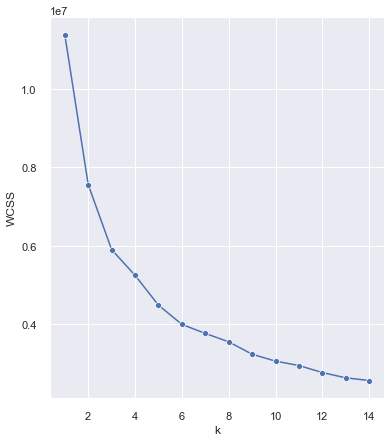

In [239]:
#plotting the graph
sns.lineplot(x=range(1,len(elbow1)+1), y=elbow1, marker='o')
sns.set(rc={'figure.figsize':(6,7)})
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

#### SILHOUETTE ANALYSIS

We ran silhouette analysis with our implementation of kmeans, but after almost 24 hours it was still running, so we decide to rewrite our silhouette analysis using the kmeans implementation from sklearn. 

We ran the new version in the other notebook in the repository. The notebook is __silhouette.ipynb__

In [243]:
silhouette1 = clustering.silhoutte_method(cluster_scores,15)

KeyboardInterrupt: 

We chose k = ... because the tecniques that we have implemeted suggested us this value

In [51]:
k = 8

#### APPLYING OUR KMEANS 

In [320]:
our_model = k_means(cluster_scores, k)

In [246]:
#we want to save our output in a json file
with open("our_cluster.json", 'w') as fp:
        json.dump(our_model[1], fp)

Now, for each cluster, we want to see which songs are grouped together.

In [247]:
cluster_0=df.iloc[our_model[1][0]]
cluster_1=df.iloc[our_model[1][1]]
cluster_2=df.iloc[our_model[1][2]]
cluster_3=df.iloc[our_model[1][3]]
cluster_4=df.iloc[our_model[1][4]]
cluster_5=df.iloc[our_model[1][5]]
cluster_6=df.iloc[our_model[1][6]]
cluster_7=df.iloc[our_model[1][7]]

#### APPLYING PYTHON'S KMEANS

In [52]:
py_model = KMeans(n_clusters=k)
py_model.fit(cluster_scores)

KMeans()

####  ANALYSING DIFFERENCES

To analyse the differences between our kmeans and the python's implementation, we will run some clustering metrics from the scikit learn library. In this way we are comparing the algorithms by considering the labels obtained from the python's implementation as the target labels. 

The metrics we are considering are:
- homogeneity in cluster
- completeness
- V measure
- ARI adjusted index

In [11]:
p = open('our_cluster.json')

In [12]:
our_model = json.load(p)

In [ ]:
list_of_df = []
for k,v in our_model.items():
    print(k)
    df_s = df_all.loc[v]
    df_s['cluster'] = k
    list_of_df.append(df_s)

In [15]:
df_merged = pd.concat(list_of_df)

In [16]:
df_merged

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223,cluster
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749,4
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085,4
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737,4
10,145,0,2008-11-26 01:50:07,2009-01-06 00:00:00,NaN,0,64,<p><em>A</em>lthough recorded in Providence in...,2014,Tom Buckland,...,6.712680,0.265904,0.214690,0.023281,0.06322,2.07918,2.01596,2.973327,20.883089,4
12,147,0,2008-11-26 01:50:13,1995-01-01 00:00:00,NaN,1,65,"<p>""Excellent accordion oriented avant-prog ba...",1446,NaN,...,1.332817,0.256045,0.249115,0.017340,0.08063,2.52739,2.44676,7.666386,106.457314,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13030,123678,0,2015-08-12 15:13:15,NaN,NaN,0,18711,<p>http://www.wfmu.org/playlists/shows/60177</p>,40471,NaN,...,4.127287,0.273919,0.289980,0.041512,0.06336,5.10902,5.04566,17.867531,420.167145,5
13031,123682,0,2015-08-12 15:13:15,NaN,NaN,0,18711,<p>http://www.wfmu.org/playlists/shows/60177</p>,40471,NaN,...,-0.069273,0.312177,0.211905,0.234971,0.06458,9.60345,9.53887,14.745868,274.562439,5
13032,123684,0,2015-08-12 15:13:15,NaN,NaN,0,18711,<p>http://www.wfmu.org/playlists/shows/60177</p>,40471,NaN,...,6.357757,0.214569,0.197370,0.009798,0.06277,0.89392,0.83115,1.422882,4.921486,5
13080,124397,0,2015-09-02 12:58:17,NaN,NaN,0,18801,<p>http://wfmu.org/playlists/shows/60273</p>,18595,NaN,...,7.022020,0.239019,0.182720,0.044364,0.06372,4.76703,4.70331,13.961578,289.356415,5


In [53]:
our_labels = df_merged['cluster']
py_labels = py_model.labels_

In [57]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(our_labels, py_labels))
print("Completeness: %0.3f" % metrics.completeness_score(our_labels, py_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(our_labels, py_labels))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(our_labels, py_labels))

Homogeneity: 0.027
Completeness: 0.027
V-measure: 0.027
Adjusted Rand-Index: 0.013


### EXERCISE 2.4 ANALYSING THE RESULTS -- PIVOT TABLES
#### Exercise 2.4 from 1. to 6. 

We are now going to create pivot tables through the following variables.
1. Track duration, we believe that this variables could be very discriminating for classification purposes. Infact, looking at the values in it, we saw that some the had a very big range, going from 18 seconds to 3033 seconds which are 45 minutes. We thought that maybe the clusters with a high percentage of long songs could all be part of a specific genre
2. audio_features_acousticness
3. audio_features_danceability
4. audio_features_speechiness
5. audio_features_energy
6. audio_features_instrumentalness
7. audio_features_liveness

We believe that these features could be a way of analysing our results. Infact we are assuming that songs belonging to different genres may have very different values with respect to the features we have selected. For example, we may assume that the value of danceability of a "classical" song is very different to the value of danceability of a "hip hop" song.

The pivot table are obtained from the initial dataset and from the results of the clusterization from the previous point.
To create the pivot table, this list of steps was performed for every one of them:
1. Since we are intrested in evaluating one features at a time, that feature get extracted from the database as a new database with only that columns
1. Then we add to this new database a list of empty columns, named cluster(i) and a column named groupization
1. The columns named cluster(i) are filled with the resulst obtained from the clusterization
1. We then categorize the values of the features in 4 range, and see each elements in which categorize it belongs
1. The database obtained after all this steps is saved and using this database the pivot table are generated using the built in pandas function

In [249]:
with open('our_cluster.json') as json_file:
    cl_results = json.load(json_file)

#### PIVOT TABLE OF TRACK DURATION

In [250]:
pivot_track_duration=df_all[['track_duration']]

In [255]:
pivot_track_duration=adding_clusters_columns(pivot_track_duration, k)
pivot_track_duration=update_cluster_columns(pivot_track_duration,cl_results,1)

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [256]:
column=pivot_track_duration['track_duration']
max_value=column.max()
min_value=column.min()
list_values=[min_value, 125, 250 , 500, max_value]

In [257]:
pivot_track_duration=filling_groupization(pivot_track_duration, 
                                           'track_duration', list_values)

In [70]:
def name_of_cluster(k):
    number_of_clusters=k
    list_of_cluster=[]
    for j in range(number_of_clusters):
            i=str(j)
            list_of_cluster.append("cluster"+i)
    return list_of_cluster

In [71]:
list1=name_of_cluster(k)

In [72]:
list1

['cluster0',
 'cluster1',
 'cluster2',
 'cluster3',
 'cluster4',
 'cluster5',
 'cluster6',
 'cluster7']

In [289]:
table_duration=pd.pivot_table(pivot_track_duration,index=['groupization'], 
                     values=list1,
                    aggfunc=np.sum)
table_duration=table_percentage(table_duration,list1)
table_duration

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
values between 125 and 250,58.599%,50.567%,45.3%,52.805%,57.518%,81.236%,37.391%,44.448%
values between 18 and 125,24.645%,8.374%,20.366%,19.536%,12.611%,7.726%,9.855%,9.905%
values between 250 and 500,15.957%,37.601%,26.893%,24.99%,28.254%,9.051%,38.744%,39.373%
values between 500 and 3033,0.798%,3.458%,7.441%,2.669%,1.617%,1.987%,14.01%,6.274%


In this pivot table we did the groupization of the duration in 4 categories:
1. duration between 18 secs and 125 sec (about 2 min)
2. duration between 125 secs and 250 sec (about 4 min)
3. duration between 250 secs and 500 sec (about 8 min)
4. duration between 500 secs and 3033 sec (about 45 min)

We see that most of the songs are in the range of 2-4 minutes (the first line in the table). We also have a very big number of songs in the range of 4-8 minutes. 
It is very interesting to notice that most of the clusters have a similar structures with respect to the duration: in each cluster there is a cospicuos number of songs that belong to each range. This is true except for cluster 5 where modt of the songs (81%) belongs to the range 2-4 min. 
We also want to underline the fact that in cluster 0 there is a very low number of songs with a duration between 8 and 45 minutes; while in cluster 6 we have most of the songs with a high duration (14%)

#### PIVOT TABLE  ACOUSTICNESS

In [290]:
pivot_audio_features_acousticness0=df_all[['audio_features_acousticness']]

In [291]:
pivot_audio_features_acousticness=adding_clusters_columns(pivot_audio_features_acousticness0,k)
pivot_audio_features_acousticness=update_cluster_columns(pivot_audio_features_acousticness, cl_results , 1)
list_values1=get_range(pivot_audio_features_acousticness, 'audio_features_acousticness' )
pivot_audio_features_acousticness=filling_groupization(pivot_audio_features_acousticness, 
                                           'audio_features_acousticness', list_values1)

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [292]:
table_acoustiness=pd.pivot_table(pivot_audio_features_acousticness,index=['groupization'], 
                     values=list1,
                    aggfunc=np.sum)
table_acoustiness=table_percentage(table_acoustiness,list1)
table_acoustiness

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
values between 0.0 and 0.25,64.362%,55.105%,2.35%,20.348%,53.638%,0.0%,40.0%,15.897%
values between 0.25 and 0.5,12.145%,17.99%,1.828%,9.246%,16.411%,0.0%,13.527%,11.562%
values between 0.5 and 0.75,10.195%,14.479%,3.786%,15.242%,14.834%,0.221%,9.952%,15.615%
values between 0.75 and 1.0,13.298%,12.426%,92.037%,55.164%,15.117%,99.779%,36.522%,56.926%


We divided the values of the acoustiness feature in 4 categories:
1. acoustiness in range 0 - 0.25
2. acoustiness in range 0.25 - 0.50
3. acoustiness in range 0.50 - 0.75
4. acoustiness in range 0.75 - 1.0

The most interesting thing to notice is that in cluster 5 nearly all the song (99.8%) have an acoustiness value in between 0.75 and 1, and that songs belonging to the first two categories of acoustiness are missing!

In cluster 2 we have a very huge number of songs that have an acoustiness value in between 0.75 and 1, while the values for the other categories are very low. 

It will be interesting to see if in cluster 2 and cluster 5 there will be particular percentages of the other values and a predominant genre. 

In all the other cluster we find a quite high percentage of songs that belong to all categories, in some clusters some categories are higher than in other, but the distribution is quite similar.

#### PIVOT TABLE DANCEABILITY

In [293]:
pivot_audio_features_danceability0=df_all[['audio_features_danceability']]

In [294]:
pivot_audio_features_danceability=adding_clusters_columns(pivot_audio_features_danceability0,k)
pivot_audio_features_danceability=update_cluster_columns(pivot_audio_features_danceability,
                                                        cl_results,1)
list_value2=get_range(pivot_audio_features_danceability, 'audio_features_danceability')
pivot_audio_features_danceability=filling_groupization(pivot_audio_features_danceability,
                                                      'audio_features_danceability',
                                                      list_value2)

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [295]:
table_dance=pd.pivot_table(pivot_audio_features_danceability,index=['groupization'], 
                     values=list1,
                    aggfunc=np.sum)
table_dance=table_percentage(table_dance,list1)
table_dance

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
values between 0.05 and 0.28,37.234%,2.701%,30.679%,26.035%,11.237%,18.322%,4.541%,10.011%
values between 0.28 and 0.51,49.468%,19.179%,51.175%,47.66%,40.097%,56.733%,20.483%,37.081%
values between 0.51 and 0.74,12.677%,49.487%,16.58%,23.985%,42.805%,23.62%,40.58%,42.016%
values between 0.74 and 0.97,0.621%,28.633%,1.567%,2.321%,5.861%,1.325%,34.396%,10.892%


In the pivot table of the danceability feature we have divided the values in 4 categories:
1. danceability in range 0.05 - 0.28
2. danceability in range 0.28 - 0.51
3. danceability in range 0.51 - 0.74
4. danceability in range 0.74 - 0.97

In this table we notice that most of the cluster have songs which belong to three categories and a little percentage belong to the other category. 
We can say that:
- for the first category most of the songs belong to cluster 0 and cluster 2
- for the second category every cluster, apart from cluster 1, has a high value
- for the third category a high percentage of songs belong to clusters 1, 4, 6, 7 
- for the last category there are only to cluster with a high percentage of songs between this values of danceability, and they are cluster 1 and in particular cluster 6 (34.3%)

#### PIVOT TABLE SPEECHINESS

In [296]:
pivot_audio_features_speechiness0=df_all[['audio_features_speechiness']]

In [297]:
pivot_audio_features_speechiness=adding_clusters_columns(pivot_audio_features_speechiness0, k)
pivot_audio_features_speechiness=update_cluster_columns(pivot_audio_features_speechiness, cl_results, 1)
list_values4=get_range(pivot_audio_features_speechiness, 'audio_features_speechiness' )
pivot_audio_features_speechiness=filling_groupization(pivot_audio_features_speechiness, 
                                                      'audio_features_speechiness' , list_values4 )

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [298]:
table_speech=pd.pivot_table(pivot_audio_features_speechiness,index=['groupization'], 
                     values=list1,
                    aggfunc=np.sum)
table_speech=table_percentage(table_speech,list1)
table_speech

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
values between 0.02 and 0.26,98.759%,79.363%,97.781%,98.53%,94.503%,85.872%,69.952%,93.127%
values between 0.26 and 0.49,0.798%,15.721%,1.697%,1.083%,4.527%,6.623%,14.686%,4.723%
values between 0.49 and 0.73,0.266%,3.674%,0.522%,0.271%,0.768%,2.428%,6.957%,1.586%
values between 0.73 and 0.97,0.177%,1.243%,0.0%,0.116%,0.202%,5.077%,8.406%,0.564%


We are assuming that the speechiness is the value that represents the portion of song that is sang by the artist, so the amount of words. Also in this case we divided the value is 4 categories:
1. speechiness in range 0.02 - 0.26
2. speechiness in range 0.26 - 0.49
3. speechiness in range 0.49 - 0.73
4. speechiness in range 0.73 - 0.97

In this table we notice that most of the songs belong to the first category and the remainung in the second, so we imagine with a low percentage of words in them. In particular in clusters 0, 2, 3, 4 and 7 more then 93% of the songs are in the first categories.

And it also possible to see that only cluster 5 and cluster 6 present a higher percentage of songs in the last category with respectively 5% and 8%. 


#### PIVOT TABLE ENERGY

In [299]:
pivot_audio_features_energy0=df_all[['audio_features_energy']]

In [300]:
pivot_audio_features_energy=adding_clusters_columns(pivot_audio_features_energy0, k)
pivot_audio_features_energy=update_cluster_columns(pivot_audio_features_energy, cl_results, 1)
list_values5=get_range(pivot_audio_features_energy, 'audio_features_energy' )
pivot_audio_features_energy=filling_groupization(pivot_audio_features_energy, 
                                                 'audio_features_energy' , list_values5 )

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [301]:
table_energy=pd.pivot_table(pivot_audio_features_energy,index=['groupization'], 
                     values=list1,
                    aggfunc=np.sum)
table_energy=table_percentage(table_energy,list1)
table_energy

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
values between 0.0 and 0.25,2.305%,4.538%,80.418%,11.025%,2.264%,77.042%,25.024%,28.093%
values between 0.25 and 0.5,4.787%,24.581%,15.666%,26.035%,17.34%,20.971%,33.816%,39.478%
values between 0.5 and 0.75,18.085%,40.194%,2.872%,35.087%,35.206%,1.766%,28.116%,24.709%
values between 0.75 and 1.0,74.823%,30.686%,1.044%,27.853%,45.19%,0.221%,13.043%,7.719%


In this pivot table we analyze the energy of the songs and we divide the values that each song could have in 4 categories:
1. energy in range 0 - 0.25
2. energy in range 0.25 - 0.50
3. energy in range 0.50 - 0.75
4. energy in range 0.75 - 1.0

In many clusters we observe that the percentage of songs cointaned in them are not very different with respect to the energy categories. 
However we can also find some cluster with a very high number of songs in a specific category. For example, we have that in cluster 0, 74.8% of the songs have an energy value in between 0.75-1. 
Cluster 2 and cluster 5 have respectively 80% and 77% of the songs belonging to the first category of energy.

And again, cluster 2 and 5 are the most distinctive. 

#### PIVOT TABLE INSTRUMENTALNESS

In [302]:
pivot_audio_features_instrumentalness0=df_all[['audio_features_instrumentalness']]

In [303]:
pivot_audio_features_instrumentalness=adding_clusters_columns(pivot_audio_features_instrumentalness0, k)
pivot_audio_features_instrumentalness=update_cluster_columns(pivot_audio_features_instrumentalness, cl_results, 1)
list_values6=get_range(pivot_audio_features_instrumentalness, 'audio_features_instrumentalness' )
pivot_audio_features_instrumentalness=filling_groupization(pivot_audio_features_instrumentalness, 
                                                           'audio_features_instrumentalness' , list_values6 )

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [304]:
table_instrumental=pd.pivot_table(pivot_audio_features_instrumentalness,index=['groupization'], 
                     values=list1,
                    aggfunc=np.sum)
table_instrumental=table_percentage(table_instrumental,list1)
table_instrumental

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
values between 0.0 and 0.25,22.074%,36.845%,7.963%,9.478%,33.872%,18.764%,27.826%,21.643%
values between 0.25 and 0.5,6.826%,6.861%,2.219%,3.752%,8.084%,2.649%,5.7%,5.886%
values between 0.5 and 0.75,10.55%,10.697%,5.744%,8.665%,14.309%,3.532%,10.725%,10.998%
values between 0.75 and 1.0,60.55%,45.597%,84.073%,78.104%,43.735%,75.055%,55.749%,61.473%


In this pivot table we analyze the instrumentalness of the songs and we divide the values that each song could have in 4 categories:
1. instrumentalness in range 0 - 0.25
2. instrumentalness in range 0.25 - 0.50
3. instrumentalness in range 0.50 - 0.75
4. instrumentalness in range 0.75 - 1.0

Also in this table most of the clusters have values which belong to all the categories, even though we have to highlight that the highest percentages are observed in the last category which contains the highest values of instrumentalness. 
However we can underline that in cluster 2 the 84% of the songs are in the last category and it's the highest value. 
It is also interesting to notice tha in the second and third categories (0.25-0.75) there are a very small number of songs. So most of the songs belong either to the first category which contains the lowest values of instrumentalness or to the last category.

#### PIVOT TABLE LIVENESS

In [305]:
pivot_audio_features_liveness0=df_all[['audio_features_liveness']]

In [306]:
pivot_audio_features_liveness=adding_clusters_columns(pivot_audio_features_liveness0, k)
pivot_audio_features_liveness=update_cluster_columns(pivot_audio_features_liveness, cl_results, 1)
list_values7=get_range(pivot_audio_features_liveness, 'audio_features_liveness' )
pivot_audio_features_liveness=filling_groupization(pivot_audio_features_liveness, 
                                                   'audio_features_liveness' , list_values7 )

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [307]:
table_liveness=pd.pivot_table(pivot_audio_features_liveness,index=['groupization'], 
                     values=list1,
                    aggfunc=np.sum)
table_liveness=table_percentage(table_liveness,list1)
table_liveness

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
values between 0.03 and 0.26,71.277%,80.443%,90.078%,83.25%,76.354%,39.294%,84.541%,85.301%
values between 0.26 and 0.5,21.277%,14.533%,6.136%,10.986%,16.653%,38.411%,10.725%,10.257%
values between 0.5 and 0.74,5.762%,3.836%,3.655%,4.565%,4.972%,10.817%,3.768%,3.631%
values between 0.74 and 0.98,1.684%,1.189%,0.131%,1.199%,2.021%,11.479%,0.966%,0.811%


In this table we categorized the values of liveness in 4 groups:
1. liveness in range 0.03 - 0.26
2. liveness in range 0.26 - 0.50
3. liveness in range 0.50 - 0.74
4. liveness in range 0.74 - 0.98

In this table we notice that most of the songs belong to the first two categories and a few in the last 2. So what is interesting to highlight is that cluster 5 has the highest percentage of songs (11.5%) that belong to the last category which has the highest values of liveness. So also here, cluster 5 has a specific characterization. We also notice that the percentage of songs in the other categories are lower with respect to the values of the other clusters.  
In all the other clusters, instead, we find a similar distribution with a high percentage of songs belonging to the first two categories.

#### PIVOT TABLE TRACK GENRES

In [61]:
pivot_track_genres0=df_genre[['track_genre_code']]

In [62]:
pivot_track_genres0['track_genre_code'] = pivot_track_genres0['track_genre_code'].apply(lambda x : genres_to_int(x))

<ipython-input-62-55ff84e9f727>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_track_genres0['track_genre_code'] = pivot_track_genres0['track_genre_code'].apply(lambda x : genres_to_int(x))


In [63]:
pivot_track_genres2=pivot_track_genres0.track_genre_code.unique()

In [64]:
list_of_values=[]
for item in pivot_track_genres2:
    list_of_values.append(item)

In [65]:
list_of_values.sort()

In [318]:
pivot_track_genres=adding_clusters_columns(pivot_track_genres0, k)
pivot_track_genres=update_cluster_columns(pivot_track_genres,cl_results,1)
pivot_track_genres=filling_groupization_for_track_genres(pivot_track_genres, 
                                           'track_genre_code', list_of_values)

/Users/camilla/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [319]:
table_genres=pd.pivot_table(pivot_track_genres,index=['groupization'], 
                     values=list1,
                     aggfunc=np.sum)
table_genres=table_percentage(table_genres, list1)
table_genres

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
Blues,0.355%,1.08%,1.305%,1.818%,1.536%,0.0%,0.58%,2.855%
Classical,0.089%,0.108%,30.287%,0.658%,0.728%,4.636%,3.671%,2.044%
Electronic,14.805%,47.92%,17.885%,8.046%,24.212%,1.766%,56.522%,21.854%
Experimental,0.089%,0.054%,0.0%,0.039%,0.202%,0.442%,0.097%,0.211%
Folk,3.901%,1.297%,19.452%,14.004%,4.891%,5.298%,2.899%,15.298%
Hip-Hop,1.241%,19.989%,1.175%,2.515%,7.478%,0.0%,9.758%,6.803%
Instrumental,0.266%,0.594%,1.436%,1.277%,0.566%,0.442%,1.353%,1.657%
International,0.975%,4.214%,1.436%,2.553%,3.395%,3.311%,3.575%,3.384%
Jazz,0.975%,3.836%,8.616%,2.089%,3.517%,0.221%,5.604%,7.014%


In the end we did the pivot table of the cluster with respect to the genres. In the original dataset we had missing values for the feature which represent the genre's label of the song (i.e. "hip-hop", "rock"..). We noticed that there were other features which were related to the genre of the song but represented the genres as a code, and often we didn't have only a single value but multiples one. In order to obtain more grouped results, we assumed that the first value of the "track_genres" feature was the prevalent one. So we got that value and mapped it to the track genre label.

So in the end we obtained this pivot table with the label of the genres, which are surely more representative and understandable.

The first thing that we want to highlight is that in most of the clusters there are songs which belong to every genre, and this could be explained by the fact that in the original dataset there are songs that present more genres in the "track_genres" feature, so originally the genres are not very differentiable.

However, it is also possible to see notice that in some clusters some genres are really prevalent. In particular, we have that:
- cluster 5, has 82% of songs that belong to the Old-Time/Historic genre; this is a greay result since by analyzing the other pivot tables we saw that this cluster always had a specific characterization.
- cluster 0, 3, 4, 7 have most of the songs which belong to the Rock genre
- cluster 6 has 56% of the songs belonging to Electronic
- cluster 1 has a very high value of electronic songs, but also present the highest number of Hip-Hop songs
- cluster 2 have a lot of songs belonging to the Classical genre (30%) and this value represents the highest one and also the more different one for this genre with respect to all the other clusters.



#### COMPARISON OUR MODEL VS PYTHON'S MODEL

To do a furter comparison to explain the differences between the two analysis, we will create the pivot table of the genres with the results of the kmeans implementation of python.

In [59]:
dd1 = defaultdict(list)
for i in range(len(py_labels)):
    if py_labels[i] not in dd1.keys():
        dd1[int(py_labels[i])] = [i]
    else:
        dd1[int(py_labels[i])].append(i)

In [60]:
with open("dd1.json", 'w') as fp:
        json.dump(dd1, fp)

In [68]:
pivot_track_genres2=adding_clusters_columns(pivot_track_genres0, k)
pivot_track_genres2=update_cluster_columns(pivot_track_genres2,dd1,1)
pivot_track_genres2=filling_groupization_for_track_genres(pivot_track_genres2, 
                                           'track_genre_code', list_of_values)

In [73]:
table_genres2=pd.pivot_table(pivot_track_genres2,index=['groupization'], 
                     values=list1,
                     aggfunc=np.sum)
table_genres2=table_percentage(table_genres2, list1)
table_genres2

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
groupization,,,,,,,,
Blues,1.611%,1.597%,1.415%,2.933%,0.431%,1.7%,0.0%,0.38%
Classical,23.953%,0.758%,13.836%,0.953%,0.072%,0.51%,1.909%,0.444%
Electronic,16.327%,32.735%,33.648%,22.727%,16.319%,8.838%,0.955%,57.958%
Experimental,0.0%,0.16%,0.157%,0.22%,0.216%,0.034%,0.477%,0.0%
Folk,25.242%,3.832%,8.491%,14.186%,4.242%,10.639%,4.535%,1.585%
Hip-Hop,0.967%,13.653%,2.201%,7.331%,1.582%,2.617%,0.0%,17.311%
Instrumental,1.933%,0.599%,2.673%,1.503%,0.288%,1.02%,0.477%,0.507%
International,1.182%,4.232%,3.616%,3.116%,1.222%,2.549%,2.625%,4.439%
Jazz,7.304%,3.992%,11.792%,6.708%,1.222%,2.073%,0.239%,2.663%


Also in this case we notice that cluster 6 can be defined as the Old-Time Historic cluster since it contains 87.5% of songs of that genre and a few of the others, in particular Blues and Hip-Hop are fully missing. This cluster 6 it's very similar to our cluster 5. 

Also we have that cluster 7 contains a very high percentage of songs of Electronic genres, and has the highest percentage of Hip-Hop songs. Similar situation in our model, but with cluster 1.

Cluster 2 has 33% of Electronic songs but it also contains the highest number of Jazz songs.

The Rock songs can be found in every cluster, but in particular in cluster 4 with 63.9%; also in cluster 4 there are not many other songs of different genres. 

We can **conclude** that our cluster analysis, with our kmeans, it's not so bad and the results we obtain with pur kmeans are not very different from the results of python's kmeans implementation.
We were able to classify some genres, some other no and we believe that these results depend a lot on the fact that more than half of the songs don't have only a single genre they belong to.


### EXERCISE 2.4.7. -- SAME ANALYSIS ON NEW DF

In this step of the homework we are doing the same kind of analysis but on different dataset. We only use the track e feature csvs so the dataset we already merged and called "data". 
This new dataset has much more observations (106574) and less features (524). We will apply the same techniques for dimensionality reduction, and implement the clustering with pythons scikit learn. 
In the end, we will compare the results. 

In [23]:
data.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [288]:
data_genre = pd.DataFrame(columns=['track_id', 'genres_code'])
data_genre['track_id']=data['track_id']
data_genre['genres_code']=data['track_genres']

#### DATA WRANGLING

1. Deleting missing values.

In [25]:
#percentage of missing value for each feature
missing_data_new=data.isna().mean()
pd.set_option('display.max_rows', None)
missing_data_new 

track_id                          0.000000
album_comments                    0.000000
album_date_created                0.033113
album_date_released               0.340421
album_engineer                    0.856485
album_favorites                   0.000000
album_id                          0.000000
album_information                 0.219800
album_listens                     0.000000
album_producer                    0.830540
album_tags                        0.000000
album_title                       0.009618
album_tracks                      0.000000
album_type                        0.061066
artist_active_year_begin          0.786899
artist_active_year_end            0.949566
artist_associated_labels          0.866093
artist_bio                        0.332332
artist_comments                   0.000000
artist_date_created               0.008032
artist_favorites                  0.000000
artist_id                         0.000000
artist_latitude                   0.582037
artist_loca

In [26]:
data = data.loc[:,missing_data_new < .30] #deleting the feature which have more than the 30% of missing values

2. We have to apply the low variance filter, so we split the dataset.

In [27]:
data_numeric_new = data.select_dtypes(include=['int64', 'float64'])

In [28]:
data_categorical_new = data.select_dtypes(include='object')

In [29]:
#we drop the unique identifiers of tracks, artists and albums
data_numeric_new=data_numeric_new.drop(['track_id', 'artist_id', 'album_id'], axis=1) 

In [30]:
#calculating the variance
data_var=data_numeric_new.var()
data_var=data_var.apply(lambda x: '%.5f' % x)
data_var

album_comments                              5.14798
album_favorites                             9.81591
album_listens                     21860562364.63435
album_tracks                             1595.49703
artist_comments                            39.66076
artist_favorites                        10102.54321
track_bit_rate                     4572930122.15205
track_comments                              0.10368
track_duration                          93341.58644
track_favorites                           182.62334
track_interest                      361662677.70194
track_listens                        64449918.30814
track_number                              232.35732
chroma_cens_kurtosis_01                  1042.35505
chroma_cens_kurtosis_02                   123.67448
chroma_cens_kurtosis_03                    99.61422
chroma_cens_kurtosis_04                   363.83871
chroma_cens_kurtosis_05                   225.76873
chroma_cens_kurtosis_06                   148.25941
chroma_cens_

In [57]:
data_numeric_new.dtypes

album_comments                      int64
album_favorites                     int64
album_listens                       int64
album_tracks                        int64
artist_comments                     int64
artist_favorites                    int64
track_bit_rate                      int64
track_comments                      int64
track_duration                      int64
track_favorites                     int64
track_interest                      int64
track_listens                       int64
track_number                        int64
chroma_cens_kurtosis_01           float64
chroma_cens_kurtosis_02           float64
chroma_cens_kurtosis_03           float64
chroma_cens_kurtosis_04           float64
chroma_cens_kurtosis_05           float64
chroma_cens_kurtosis_06           float64
chroma_cens_kurtosis_07           float64
chroma_cens_kurtosis_08           float64
chroma_cens_kurtosis_09           float64
chroma_cens_kurtosis_10           float64
chroma_cens_kurtosis_11           

In [31]:
#removing the features with the variance below a threshold
data_reduced = data_numeric_new.loc[:, data_numeric_new.var() > 70]
data_reduced.head()

,album_listens,album_tracks,artist_favorites,track_bit_rate,track_duration,track_favorites,track_interest,track_listens,track_number,chroma_cens_kurtosis_01,...,spectral_centroid_min_01,spectral_centroid_std_01,spectral_contrast_max_01,spectral_rolloff_kurtosis_01,spectral_rolloff_max_01,spectral_rolloff_mean_01,spectral_rolloff_median_01,spectral_rolloff_min_01,spectral_rolloff_std_01,zcr_kurtosis_01
0,6073,7,9,256000,168,2,4656,1293,3,7.180653,...,0.000000,719.770508,50.825714,0.840540,9410.009766,3267.804688,3143.847656,0.000000,1300.729736,5.758890
1,6073,7,9,256000,237,1,1470,514,4,1.888963,...,0.000000,972.758423,59.697681,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1650.357788,2.824694
2,6073,7,9,256000,206,6,1933,1151,6,0.527563,...,0.000000,665.319275,50.931419,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,1323.465210,6.808415
3,47632,2,74,192000,161,178,54881,50135,1,3.702245,...,0.000000,668.700806,58.622181,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1524.401245,21.434212
4,2710,13,10,256000,311,0,978,361,3,-0.193837,...,123.611168,481.929871,46.735180,-0.744805,9496.142578,4201.346191,4166.674805,75.366211,1495.297119,16.669037


In [32]:
#lets check the new shape of the dataset
data_reduced.shape

(106574, 115)

#### DIMENSIONALITY REDUCTION 

Again we will apply PCA for numerical features and MCA for categorical features. 

#### SCALING AND PCA

Preprocessing data to apply the scaler

In [33]:
#we check if where NaN values are
np.where(np.isnan(data_reduced))

(array([], dtype=int64), array([], dtype=int64))

In [34]:
#we replace NaN values 
data_toscale=np.nan_to_num(data_reduced)

In [35]:
#we do the final control of NaN values
np.where(np.isnan(data_toscale))

(array([], dtype=int64), array([], dtype=int64))

Scaling

In [36]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_toscale)
data_scaled

array([[-0.17617091, -0.31848627, -0.2093495 , ..., -0.50285199,
         0.03579914, -0.26643162],
       [-0.17617091, -0.31848627, -0.2093495 , ..., -0.50285199,
         0.6480995 , -0.29940939],
       [-0.17617091, -0.31848627, -0.2093495 , ..., -0.50285199,
         0.07561556, -0.25463589],
       ...,
       [-0.2070598 , -0.34352164, -0.298892  , ...,  0.00353153,
        -0.6085246 , -0.30466893],
       [-0.2070598 , -0.34352164, -0.298892  , ...,  0.25672329,
        -0.91435112, -0.26160202],
       [-0.1666479 , -0.21834478, -0.179502  , ..., -0.12306435,
         1.32381574, -0.0866377 ]])

In [37]:
#creating a dataset with the scaled values
data_scaled_df=pd.DataFrame(data_scaled, columns=data_reduced.columns)
data_scaled_df.head()

,album_listens,album_tracks,artist_favorites,track_bit_rate,track_duration,track_favorites,track_interest,track_listens,track_number,chroma_cens_kurtosis_01,...,spectral_centroid_min_01,spectral_centroid_std_01,spectral_contrast_max_01,spectral_rolloff_kurtosis_01,spectral_rolloff_max_01,spectral_rolloff_mean_01,spectral_rolloff_median_01,spectral_rolloff_min_01,spectral_rolloff_std_01,zcr_kurtosis_01
0,-0.176171,-0.318486,-0.209350,-0.107577,-0.359551,-0.087505,0.058614,-0.129092,-0.345134,0.208784,...,-0.745245,0.410141,-1.028098,-0.159913,0.157138,0.796200,0.787324,-0.502852,0.035799,-0.266432
1,-0.176171,-0.318486,-0.209350,-0.107577,-0.133705,-0.161504,-0.108917,-0.226127,-0.279531,0.044880,...,-0.745245,1.265406,0.012595,-0.147082,0.738211,1.011750,0.997854,-0.502852,0.648100,-0.299409
2,-0.176171,-0.318486,-0.209350,-0.107577,-0.235172,0.208490,-0.084571,-0.146780,-0.148325,0.002712,...,-0.745245,0.226061,-1.015699,-0.168912,0.188833,0.364887,0.568373,-0.502852,0.075616,-0.254636
3,0.104913,-0.443663,0.437346,-1.053999,-0.382463,12.936260,2.699625,5.954839,-0.476340,0.101044,...,-0.745245,0.237492,-0.113563,-0.136736,0.791036,0.216037,-0.105322,-0.502852,0.427513,-0.090255
4,-0.198917,-0.168274,-0.199400,-0.107577,0.108508,-0.235502,-0.134788,-0.245185,-0.345134,-0.019632,...,-0.142607,-0.393915,-1.507923,-0.173134,0.241658,1.611487,1.587338,-0.281309,0.376543,-0.143811


PCA

In [38]:
#>80% of variance
pca_model_new = PCA(n_components=0.80) #maintain 80% of variance
pca_model_new.fit(data_scaled_df) # fit the model 
pca_scores_new = pca_model_new.transform(data_scaled_df) # transform the 'normalized model'

In [39]:
pca_scores_new.shape

(106574, 32)

In [40]:
print(pca_model_new.explained_variance_ratio_)

[0.13704778 0.10125957 0.06180383 0.06153581 0.03789676 0.0359568
 0.03032353 0.02591512 0.02515019 0.02183218 0.02137292 0.01821364
 0.01615371 0.01577771 0.01474256 0.01460901 0.01418637 0.01379766
 0.01329033 0.01210964 0.01109692 0.01046154 0.01011472 0.00935332
 0.00894744 0.00863774 0.00856425 0.00846316 0.00818559 0.00804737
 0.00793608 0.00785004]


The first two components explain most of the variance.

We create a dataframe with the values we obtained in the PCA analysis in order to merge them later with the results of MCA.

In [23]:
columns_new = ['pca_comp_%i' % i for i in range(1,33)]
data_pca_new  = pd.DataFrame(pca_model_new.transform(data_scaled_df), columns=columns_new, 
                             index=data_scaled_df.index)
data_pca_new.head()

,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,...,pca_comp_23,pca_comp_24,pca_comp_25,pca_comp_26,pca_comp_27,pca_comp_28,pca_comp_29,pca_comp_30,pca_comp_31,pca_comp_32
0,-2.483529,2.160571,-0.269129,1.771218,-0.411761,-0.117098,2.116108,-0.020108,0.631427,0.034007,...,0.054698,-0.040437,0.265532,-0.709791,-0.016094,-0.626651,0.460811,-0.081096,0.893221,-0.500487
1,-3.559066,3.332923,0.348904,-0.708306,-0.093592,-0.224659,1.680578,-0.122963,0.545821,-0.178720,...,-0.004702,-0.988074,0.188616,-0.076912,0.379364,0.057168,-0.254457,0.048028,0.274465,0.188618
2,-1.796667,1.584594,0.054188,-0.145885,-0.072837,-0.020529,0.341162,-0.071854,0.262432,0.341762,...,0.193987,0.251715,-0.098547,-0.301093,-0.180477,-0.039410,-0.095350,0.080753,0.400510,-0.157689
3,1.077499,0.921145,-0.282457,0.502107,2.334413,-0.618676,1.482516,-5.099286,9.053869,4.714782,...,0.041420,0.502158,0.624929,-0.393234,0.830971,-1.685340,-1.744451,-0.286590,1.224155,0.156842
4,-0.146750,4.390334,0.532115,-1.188555,0.969879,0.559932,-3.047707,0.065869,-1.021451,-0.116855,...,0.194824,-0.187935,0.052745,-1.310101,-0.363321,-1.295794,0.324561,0.407556,0.543605,-0.538536


In [24]:
data_pca_new['track_id']=data_genre['track_id']

In [25]:
data_pca_new.head()

,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,...,pca_comp_24,pca_comp_25,pca_comp_26,pca_comp_27,pca_comp_28,pca_comp_29,pca_comp_30,pca_comp_31,pca_comp_32,track_id
0,-2.483529,2.160571,-0.269129,1.771218,-0.411761,-0.117098,2.116108,-0.020108,0.631427,0.034007,...,-0.040437,0.265532,-0.709791,-0.016094,-0.626651,0.460811,-0.081096,0.893221,-0.500487,2
1,-3.559066,3.332923,0.348904,-0.708306,-0.093592,-0.224659,1.680578,-0.122963,0.545821,-0.178720,...,-0.988074,0.188616,-0.076912,0.379364,0.057168,-0.254457,0.048028,0.274465,0.188618,3
2,-1.796667,1.584594,0.054188,-0.145885,-0.072837,-0.020529,0.341162,-0.071854,0.262432,0.341762,...,0.251715,-0.098547,-0.301093,-0.180477,-0.039410,-0.095350,0.080753,0.400510,-0.157689,5
3,1.077499,0.921145,-0.282457,0.502107,2.334413,-0.618676,1.482516,-5.099286,9.053869,4.714782,...,0.502158,0.624929,-0.393234,0.830971,-1.685340,-1.744451,-0.286590,1.224155,0.156842,10
4,-0.146750,4.390334,0.532115,-1.188555,0.969879,0.559932,-3.047707,0.065869,-1.021451,-0.116855,...,-0.187935,0.052745,-1.310101,-0.363321,-1.295794,0.324561,0.407556,0.543605,-0.538536,20


## MCA

we tried to apply MCA to the categorical features of the new dataset but the we ran out of memory, so we continue our analysis only with numerical features and PCA.

In [27]:
columns_mca_new=['album_title','artist_tags','album_tags', 'track_date_created'  ]

In [28]:
data_for_mca_new = pd.DataFrame(columns=columns_mca_new)
data_for_mca_new['album_title']=data_categorical_new['album_title']
data_for_mca_new['artist_tags']=data_categorical_new['artist_tags']
data_for_mca_new['album_tags']=data_categorical_new['album_tags']
data_for_mca_new['track_date_created']=data_categorical_new['track_date_created']

In [ ]:
mca_new = MCA(n_components = 2, random_state = 101)
mca_new.fit(data_for_mca_new)
categorical_mca_data = mca.transform(data_for_mca_new)
categorical_mca_data.head()

In [345]:
data_for_mca_new['track_id']=data['track_id']

In [346]:
data_cluster_new=pd.merge(data_for_mca_new, data_pca_new, on='track_id')
data_cluster_new.head()

,pca_comp_1_x,pca_comp_2_x,pca_comp_3_x,pca_comp_4_x,pca_comp_5_x,pca_comp_6_x,pca_comp_7_x,pca_comp_8_x,pca_comp_9_x,pca_comp_10_x,pca_comp_11_x,pca_comp_12_x,pca_comp_13_x,pca_comp_14_x,pca_comp_15_x,pca_comp_16_x,pca_comp_17_x,pca_comp_18_x,pca_comp_19_x,pca_comp_20_x,pca_comp_21_x,pca_comp_22_x,pca_comp_23_x,pca_comp_24_x,pca_comp_25_x,pca_comp_26_x,pca_comp_27_x,pca_comp_28_x,pca_comp_29_x,pca_comp_30_x,pca_comp_31_x,pca_comp_32_x,pca_comp_33,album_title,artist_tags,album_tags,track_date_created,track_id,pca_comp_1_y,pca_comp_2_y,pca_comp_3_y,pca_comp_4_y,pca_comp_5_y,pca_comp_6_y,pca_comp_7_y,pca_comp_8_y,pca_comp_9_y,pca_comp_10_y,pca_comp_11_y,pca_comp_12_y,pca_comp_13_y,pca_comp_14_y,pca_comp_15_y,pca_comp_16_y,pca_comp_17_y,pca_comp_18_y,pca_comp_19_y,pca_comp_20_y,pca_comp_21_y,pca_comp_22_y,pca_comp_23_y,pca_comp_24_y,pca_comp_25_y,pca_comp_26_y,pca_comp_27_y,pca_comp_28_y,pca_comp_29_y,pca_comp_30_y,pca_comp_31_y,pca_comp_32_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AWOL - A Way Of Life,['awol'],[],2008-11-26 01:48:12,2,-2.483529,2.160571,-0.269129,1.771218,-0.411761,-0.117098,2.116108,-0.020108,0.631427,0.034007,-0.324468,-1.318857,-0.059017,-0.110289,-1.342947,0.535683,-0.330752,0.118527,-0.869281,0.276715,0.361365,-0.424864,0.054698,-0.040437,0.265532,-0.709791,-0.016094,-0.626651,0.460811,-0.081096,0.893221,-0.500487
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AWOL - A Way Of Life,['awol'],[],2008-11-26 01:48:14,3,-3.559066,3.332923,0.348904,-0.708306,-0.093592,-0.224659,1.680578,-0.122963,0.545821,-0.178720,-1.828628,-0.720110,-0.793577,-0.032150,-1.207160,0.802567,-0.737548,0.248587,-0.342683,0.104958,-0.297066,-0.253263,-0.004702,-0.988074,0.188616,-0.076912,0.379364,0.057168,-0.254457,0.048028,0.274465,0.188618
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AWOL - A Way Of Life,['awol'],[],2008-11-26 01:48:20,5,-1.796667,1.584594,0.054188,-0.145885,-0.072837,-0.020529,0.341162,-0.071854,0.262432,0.341762,-0.314443,-1.457846,-1.284047,-0.137211,-1.099077,0.889976,-0.407925,0.369077,-0.485809,-0.079798,-0.676844,0.254810,0.193987,0.251715,-0.098547,-0.301093,-0.180477,-0.039410,-0.095350,0.080753,0.400510,-0.157689
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Constant Hitmaker,"['philly', 'kurt vile']",[],2008-11-25 17:49:06,10,1.077499,0.921145,-0.282457,0.502107,2.334413,-0.618676,1.482516,-5.099286,9.053869,4.714782,3.048366,2.464305,-0.109276,0.326594,-1.114848,-1.248688,-1.044650,1.051943,-0.592056,0.012679,0.371709,0.064481,0.041420,0.502158,0.624929,-0.393234,0.830971,-1.685340,-1.744451,-0.286590,1.224155,0.156842
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Niris,"['instrumentals', 'experimental pop', 'post pu...",[],2008-11-26 01:48:56,20,-0.146750,4.390334,0.532115,-1.188555,0.969879,0.559932,-3.047707,0.065869,-1.021451,-0.116855,-0.365650,0.463819,-0.731034,-0.126743,0.296594,-2.367297,0.557478,-0.728226,0.303356,0.077680,0.672298,1.155168,0.194824,-0.187935,0.052745,-1.310101,-0.363321,-1.295794,0.324561,0.407556,0.543605,-0.538536


#### HOW MANY CLUSTERS?

To choose the number of clusters for this new dataset, we will still implement the elbow method and the silhouette analysis; but we will use the functions already implemented in python due to the computational cost of our own implemented algorithms on a so large dataset. 

In [ ]:
#non so se è necessario
data_cluster_scores = data_cluster_new.to_numpy()
data_cluster_scores

ELBOW METHOD

In [26]:
new_model_py=KMeans()

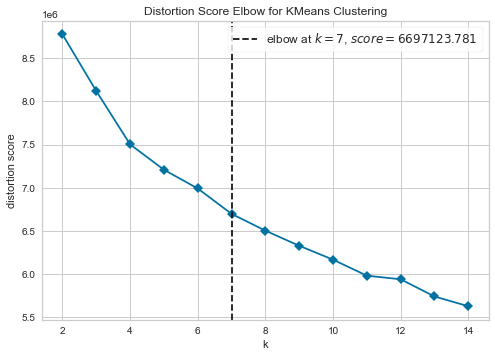

In [27]:
visualizer = KElbowVisualizer(new_model_py, k=(2,15), metric='distortion', timings=False) #there are also other metrics
visualizer.fit(pca_scores_new)
visualizer.show()

OUR ELBOW

## prova = elbow(pca_scores, 15)

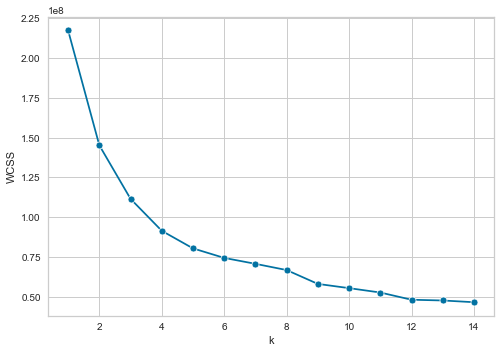

In [134]:
sns.lineplot(x=range(1,len(prova)+1), y=prova, marker='o')
sns.set(rc={'figure.figsize':(6,7)})
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

SILHOUETTE ANALYSIS

For n_clusters = 2 The average silhouette_score is : 0.13497701542784987
For n_clusters = 3 The average silhouette_score is : 0.13518632060485014
For n_clusters = 4 The average silhouette_score is : 0.12304798121269456
For n_clusters = 5 The average silhouette_score is : 0.09247478601949853
For n_clusters = 6 The average silhouette_score is : 0.08785255324843029
For n_clusters = 7 The average silhouette_score is : 0.08840659446097135
For n_clusters = 8 The average silhouette_score is : 0.08975030839538689
For n_clusters = 9 The average silhouette_score is : 0.08572443584478864


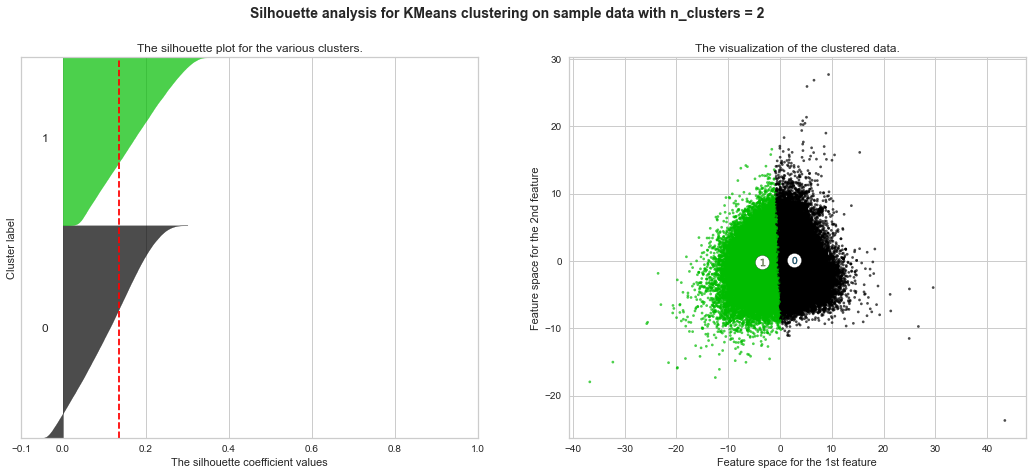

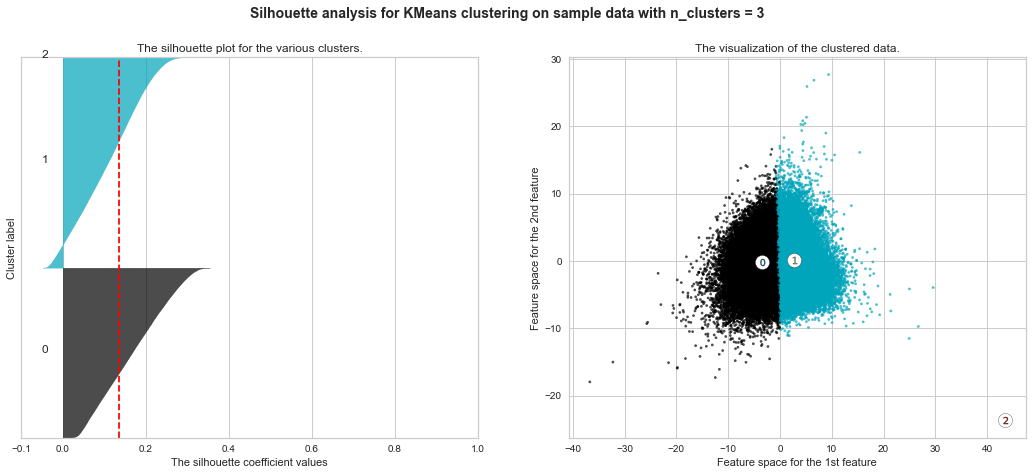

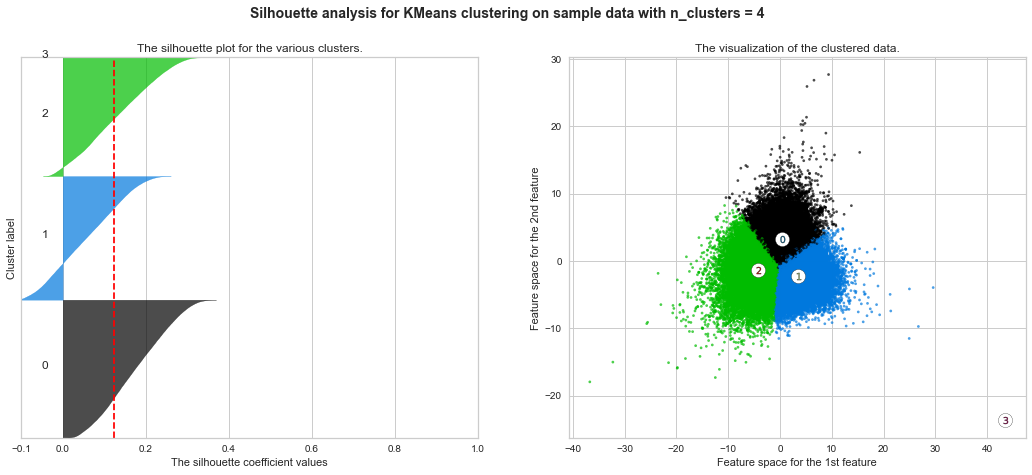

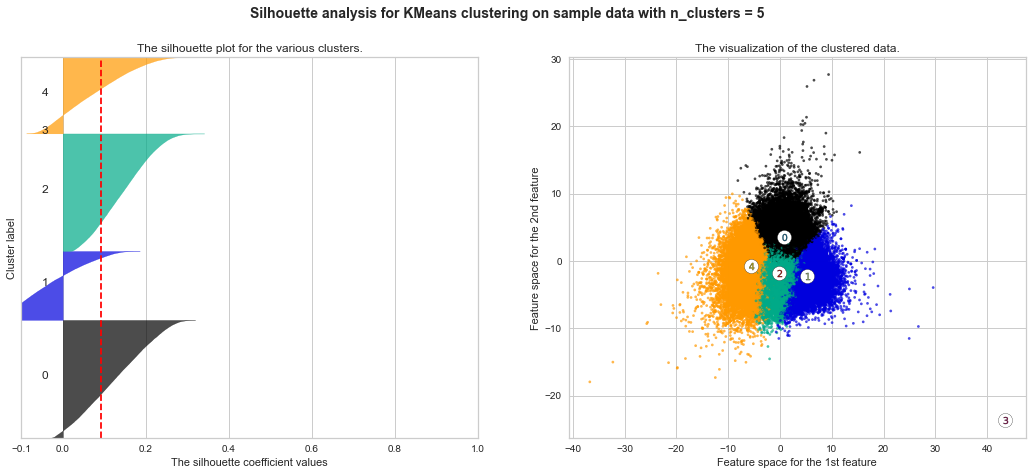

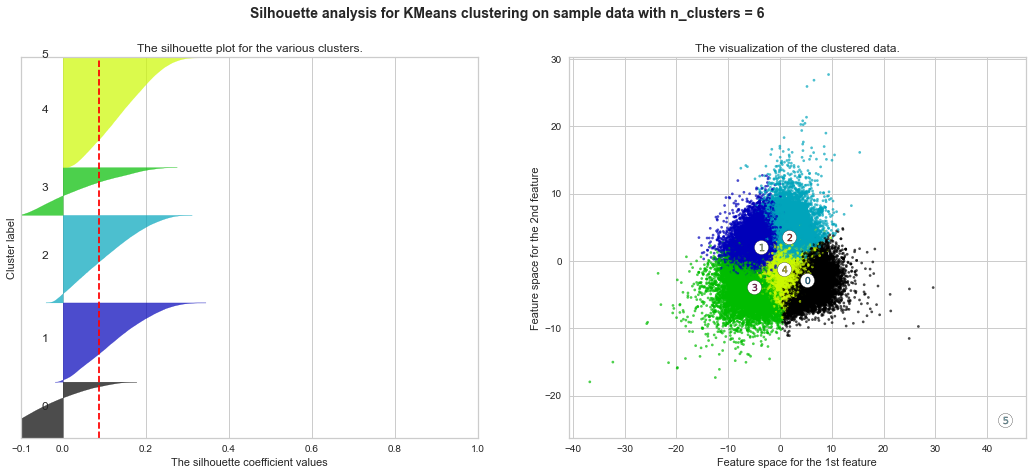

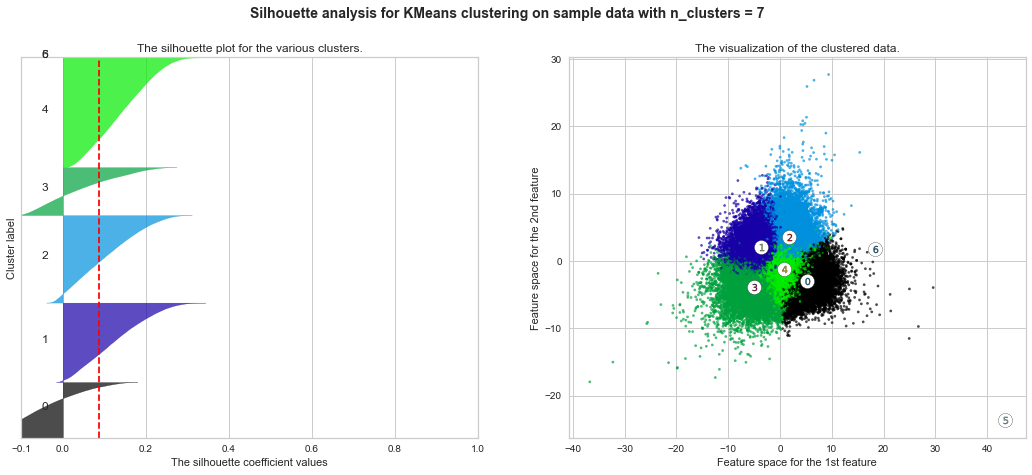

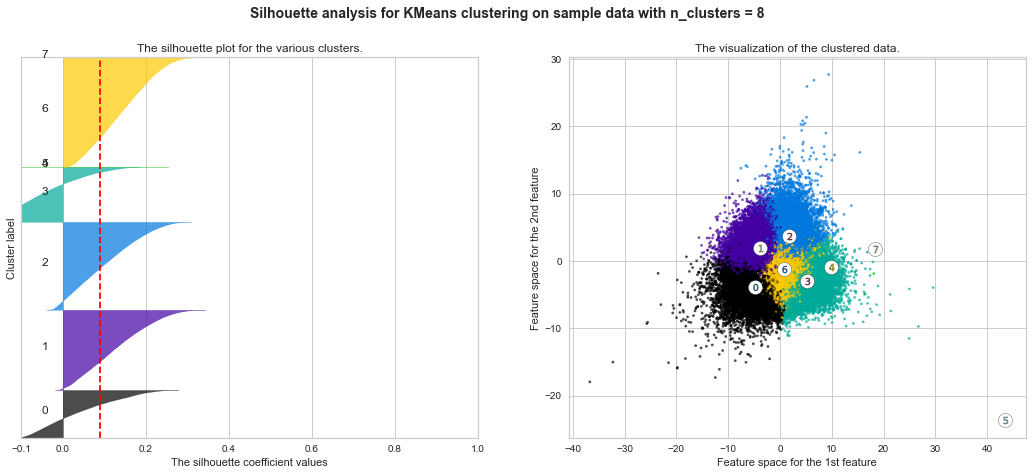

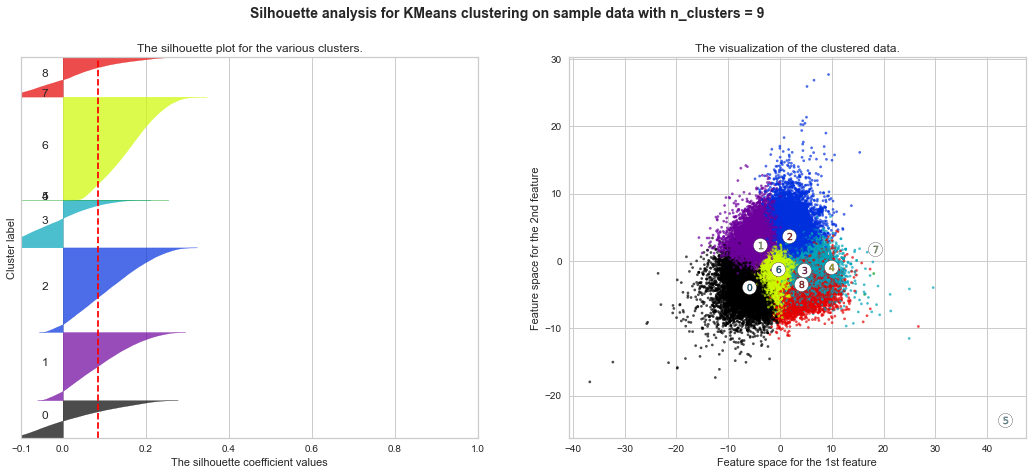

In [30]:
range_n_clusters = range(2,10)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pca_scores_new) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pca_scores_new)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca_scores_new, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_scores_new, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        pca_scores_new[:, 0], pca_scores_new[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Given the results of these analysis, we decide to choose k = .... 

In [41]:
#number of clusters
k_new = 7

#### CLUSTERING WITH KMEANS

In [42]:
py_model_new = KMeans(n_clusters=k_new)
py_model_new.fit(pca_scores_new)

KMeans(n_clusters=7)

In [44]:
def get_rows(cluster_dict,point_matrix):
    for k,v in cluster_dict.items():
        supp = []
        for val in v:
            supp.append(point_matrix[val])
        cluster_dict[k] = supp
    return cluster_dict

### PIVOT TABLES

In [45]:
test_list = py_model_new.labels_

In [47]:
dd = defaultdict(list)
for i in range(len(test_list)):
    if test_list[i] not in dd.keys():
        dd[int(test_list[i])] = [i]
    else:
        dd[int(test_list[i])].append(i)

In [48]:
with open("dd.json", 'w') as fp:
        json.dump(dd, fp)

#### PIVOT TABLE TRACK DURATION

In [49]:
pivot_track_duration0_new=data[['track_duration']]

In [50]:
column=pivot_track_duration0_new['track_duration']
max_value=column.max()
min_value=column.min()
list_values=[min_value, 125, 250 , 500, max_value]

In [51]:
pivot_track_duration_new=adding_clusters_columns(pivot_track_duration0_new, k_new)
pivot_track_duration_new=update_cluster_columns(pivot_track_duration_new,dd,1)
pivot_track_duration_new=filling_groupization(pivot_track_duration_new, 
                                           'track_duration', list_values)

C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [52]:
def name_of_cluster(k):
    number_of_clusters=k
    list_of_cluster=[]
    for j in range(k):
            i=str(j)
            list_of_cluster.append("cluster"+i)
    return list_of_cluster

In [53]:
lista = name_of_cluster(7)
lista

['cluster0',
 'cluster1',
 'cluster2',
 'cluster3',
 'cluster4',
 'cluster5',
 'cluster6']

In [54]:
table_duration_new=pd.pivot_table(pivot_track_duration_new,index=['groupization'], 
                     values=lista,
                    aggfunc=np.sum)
table_duration_new=table_percentage(table_duration_new,lista)
table_duration_new

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
groupization,,,,,,,
values between 0 and 125,8.878%,14.102%,27.34%,11.518%,27.728%,0.0%,0.0%
values between 125 and 250,31.235%,43.619%,49.322%,47.115%,40.538%,0.0%,100.0%
values between 250 and 500,36.618%,33.917%,20.211%,36.17%,23.636%,0.0%,0.0%
values between 500 and 18350,23.269%,8.362%,3.128%,5.197%,8.098%,100.0%,0.0%


In this pivot table we want to study the duration of the songs for each cluster. We group the duration in 4 categories:
1. duration in range 0 - 125 sec (about 2 min)
2. duration between 125 secs and 250 sec (about 4 min)
3. duration between 250 secs and 500 sec (about 8 min)
4. duration between 500 secs and 3033 sec (about 45 min)

We immediately notice that in cluster 5 all the songs (100%) belong to the second category. This is in line with the rest of the clusters in which most of the songs belong to the second category, infact the duration included in that range is the most common.

The only cluster that doesn't have this structure is cluster 4, which has no songs in that range and all the songs are equally distributed in the other categories. It is also important to underline that this cluster has the highest number of songs with a duration in between 8 and 45 minutes. 

Cluster 6 has many "long" songs, since it has an high percentage in the last three categories. 

All the other clusters have many songs concentrated in between 0 and 8 minutes, while a few longer than 8 minutes.

In [55]:
# da trovare altre variabili track_listens,track_bit_rate,track_favorites,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_01

#### PIVOT TABLE TRACK LISTENS

In [155]:
pivot_audio_track_listens0=data[['track_listens']]

In [156]:
pivot_audio_track_listens_new=adding_clusters_columns(pivot_audio_track_listens0,k_new)
pivot_audio_track_listens_new=update_cluster_columns(pivot_audio_track_listens_new, dd , 1)
list_values1=get_range(pivot_audio_track_listens_new, 'track_listens' )
pivot_audio_track_listens_new=filling_groupization(pivot_audio_track_listens_new, 
                                           'track_listens', list_values1)

C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [157]:
table_listens_new=pd.pivot_table(pivot_audio_track_listens_new,index=['groupization'], 
                     values=lista,
                    aggfunc=np.sum)
table_listens_new=table_percentage(table_listens_new,lista)
table_listens_new

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
groupization,,,,,,,
values between 0.0 and 530.52,39.961%,38.423%,47.145%,35.973%,37.909%,100.0%,100.0%
values between 1061.04 and 1591.56,10.578%,10.804%,10.036%,10.932%,9.449%,0.0%,0.0%
values between 1591.56 and 2122.08,30.135%,32.057%,23.084%,33.304%,35.667%,0.0%,0.0%
values between 530.52 and 1061.04,19.326%,18.716%,19.735%,19.791%,16.975%,0.0%,0.0%


The track listens represent the number of times each song has been reproduced by users. We divided the amount of times a song was listened into 4 groups:
1. listens in range 0 - 530
2. listens in range 530 - 1061
3. listens in range 1061 - 1591
4. listens in range 1591 - 2122
In this table the categories are not ordered sequentially.  

It is still interesting to notice that most of the songs are grouped in the first category, and also here cluster 5 and cluster 6 have all there songs in this range. 

All the other cluster have a similar structure, with a lot of songs belonging to the first and last categories, and less songs contained in the two intermediate classes.

#### PIVOT TABLE TRACK BIT RATE

In [139]:
pivot_audio_bit_rate0_new=data[['track_bit_rate']]

In [140]:
pivot_audio_bit_rate_new=adding_clusters_columns(pivot_audio_bit_rate0_new,k_new)
pivot_audio_bit_rate_new=update_cluster_columns(pivot_audio_bit_rate_new,
                                                        dd,1)
list_value2=get_range(pivot_audio_bit_rate_new, 'track_bit_rate')
pivot_audio_bit_rate_new=filling_groupization(pivot_audio_bit_rate_new,
                                                      'track_bit_rate',list_value2)

C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [141]:
table_track_bit_rate_new=pd.pivot_table(pivot_audio_bit_rate_new,index=['groupization'], 
                     values=lista,
                    aggfunc=np.sum)
table_track_bit_rate_new=table_percentage(table_track_bit_rate_new,lista)
table_track_bit_rate_new

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
groupization,,,,,,,
values between 223999.0 and 251999.0,29.578%,29.156%,32.317%,26.799%,35.86%,0.0%,0.0%
values between 251999.0 and 279999.0,17.423%,17.604%,26.684%,14.187%,17.847%,0.0%,0.0%
values between 279999.0 and 307999.0,0.601%,0.735%,1.099%,0.98%,0.279%,0.0%,0.0%
values between 307999.0 and 335999.0,52.399%,52.506%,39.901%,58.034%,46.014%,100.0%,100.0%


In this pivot table we group the values of the bit rate in 4 categories:
1. 223999.0 - 251999.0
2. 251999.0 - 279999.0
3. 279999.0 - 307999.0
4. 307999.0 - 335999.0


In this pivot table we notice that most of the songs of every cluster belong to the last category; in particular also here we observe that cluster 5 and cluster 6 have all their songs in the last category. 

It is also interesting to underline that a significant number of songs belong to the first two categories, while the third category is nearly empty.


#### PIVOT TABLE TRACK FAVORITES

In [122]:
pivot_track_favorites0_new=data[['track_favorites']]

In [123]:
pivot_audio_track_favorites_new=adding_clusters_columns(pivot_track_favorites0_new, k_new)
pivot_audio_track_favorites_new=update_cluster_columns(pivot_audio_track_favorites_new, dd, 1)
list_values4=get_range(pivot_audio_track_favorites_new, 'track_favorites' )
pivot_audio_track_favorites_new=filling_groupization(pivot_audio_features_speechiness_new, 
                                                      'track_favorites' , list_values4 )

C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [124]:
table_track_favorites_new=pd.pivot_table(pivot_audio_track_favorites_new,index=['groupization'], 
                     values=lista,
                    aggfunc=np.sum)
table_speech_new=table_percentage(table_track_favorites_new,lista)
table_track_favorites_new

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
groupization,,,,,,,
values between 0.0 and 2.0,76.717%,71.763%,78.838%,70.301%,68.938%,100.0%,100.0%
values between 2.0 and 4.0,10.289%,11.634%,9.884%,12.625%,11.252%,0.0%,0.0%
values between 4.0 and 6.0,4.768%,5.579%,4.079%,6.107%,5.17%,0.0%,0.0%
values between 6.0 and 8.0,8.227%,11.024%,7.199%,10.967%,14.639%,0.0%,0.0%


In this pivot table we want to see how many songs were classified as favourite. 
So, we categorize the values in 4 groups:
1. 0 - 2 
2. 2 - 4
3. 4 - 6
4. 6 - 8

Most of the songs belong to the first group, in particular cluster 5 and 6 have that all the songs that belong to this group. This means that not many users vote as favorite a song. 
however there are also a significant number of songs that have more favorites

#### PIVOT TABLE chroma_cqt_kurtosis_01

In [190]:
pivot_audio_chroma_cqt_kurtosis_010_new=data[['chroma_cqt_kurtosis_01']]

In [191]:
pivot_chroma_cqt_kurtosis_new=adding_clusters_columns(pivot_audio_chroma_cqt_kurtosis_010_new, k_new)
pivot_chroma_cqt_kurtosis_new=update_cluster_columns(pivot_chroma_cqt_kurtosis_new, dd, 1)
list_values5=get_range(pivot_chroma_cqt_kurtosis_new, 'chroma_cqt_kurtosis_01' )
pivot_chroma_cqt_kurtosis_new=filling_groupization(pivot_chroma_cqt_kurtosis_new,
                                                 'chroma_cqt_kurtosis_01' , list_values5 )

C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Francesco\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [192]:
table_kurtosis_new=pd.pivot_table(pivot_chroma_cqt_kurtosis_new,index=['groupization'], 
                     values=lista,
                    aggfunc=np.sum)
table_kurtosis_new=table_percentage(table_kurtosis_new,lista)
table_kurtosis_new

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
groupization,,,,,,,
values between 0.0 and 0.03,88.214%,78.337%,83.872%,87.467%,73.35%,0.0%,0.0%
values between 0.03 and 0.06,0.42%,0.702%,0.648%,0.499%,0.799%,0.0%,0.0%
values between 0.06 and 0.1,0.543%,0.686%,0.574%,0.521%,0.685%,0.0%,0.0%
values between 0.1 and 0.13,10.824%,20.275%,14.906%,11.514%,25.166%,100.0%,100.0%


The curtosis  is a specific feature of the song extracted with the librosa library. We divided the values of this features into 4 groups:
1. values in range 0 - 0.03
2. values in range 0.03 - 0.06
3. values in range 0.06 - 0.1
4. values in range 0.1 - 0.13 

In this table we observe that all the cluster have the same distributions apart from cluster 5 and 6 as always. 
The usual structure is that most of the values are concentrated in the first and last category, while the in between ones are quite empty. Cluster 5 and cluster 6 instead have a own distribution, with all the songs that belong to the last category. 
3. listens in range 1061 - 1591
4. listens in range 1591 - 2122

#### PIVOT TABLE GENRES

In [289]:
data_genre['genres_code'] = data_genre['genres_code'].apply(lambda x : utilities.genres_to_int(x))

In [310]:
pivot_track_genres0_new=data_genre[['genres_code']].fillna(0)

In [311]:
pivot_track_genres0_new.shape

(106574, 1)

In [312]:
pivot_track_genres_new=pivot_track_genres0_new.genres_code.unique()

In [313]:
list_of_values_new=[]
for item in pivot_track_genres_new:
    list_of_values_new.append(item)

In [314]:
list_of_values_new.sort()

In [315]:
pivot_track_genres_new2=adding_clusters_columns(pivot_track_genres0_new, k_new)
pivot_track_genres_new2=update_cluster_columns(pivot_track_genres_new2,dd,1)
pivot_track_genres_new2=filling_groupization_for_track_genres(pivot_track_genres_new2, 
                                           'genres_code', list_of_values_new)

In [316]:
table_genres_new=pd.pivot_table(pivot_track_genres_new2,index=['groupization'], 
                     values=lista,
                     aggfunc=np.sum)
table_genres_new=table_percentage(table_genres_new, lista)
table_genres_new

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
groupization,,,,,,,
Blues,0.789%,1.864%,1.927%,1.308%,1.53%,0.0%,0.0%
Classical,2.294%,1.09%,0.213%,0.28%,6.707%,0.0%,0.0%
Electronic,22.922%,19.271%,11.962%,32.438%,13.169%,0.0%,0.0%
Experimental,0.152%,0.066%,0.102%,0.061%,0.153%,0.0%,0.0%
Folk,2.793%,7.486%,3.882%,1.872%,7.253%,0.0%,0.0%
Hip-Hop,3.234%,2.78%,1.82%,9.655%,0.499%,0.0%,0.0%
Instrumental,3.943%,4.161%,1.332%,1.172%,5.43%,0.0%,0.0%
International,2.098%,1.523%,1.8%,1.64%,1.065%,0.0%,0.0%
Jazz,2.286%,2.386%,0.881%,1.833%,1.291%,0.0%,0.0%


### Compairing results

By analyzing the pivot table of the songs genres we observe that cluster 5 and cluster 6 are fully filled by rock songs. This genre is predominant in all the clusters and we see in every cluster we have at least 42% of songs belonging to the rock genre. We also notice that there is a very small number of songs belonging to the other genres, in particular the lowest are blues, classical, experimental, old time historic. 
In cluster 3 we find most of the electronic songs (32%) and also hip hop songs.

In the end we can say that apart from cluster 5 and cluster 6 we don’t have a great classification, since in every cluster we have a high percentage of songs belonging to different genres.This is also due to the fact that we have a very large number of rock songs

# EXERCISE 3

We decided to sort the list before running our algorithm. We start from the first element of the the list. We check if the ith element of the list is lesser than the sum or greater than the sum. 

If it is lesser than the sum we initialize a variable x = sum - list[i], otherwise if it is greater than the sum we initialize x = list[i] - s.This variable x represent the element that if is added to the ith element of the list will return the input sum looking. 

Then we work only on half of the original list, if list[middle position] == x then we have found the couple (list[i],x) if list[middle position] is lesser than x we have to search the element that summed to x is equal to s in the right half of the list, otherwise we search the element in the left half of the list

In [317]:
def merge_sort(list):
    list_length = len(list)

    if list_length == 1:
        return list

    mid_point = list_length // 2

    left_partition = merge_sort(list[:mid_point])
    right_partition = merge_sort(list[mid_point:])

    return merge(left_partition, right_partition)


def merge(left, right):
    output = []
    i = j = 0

    while i < len(left) and j < len(right):
        if left[i] < right[j]:
            output.append(left[i])
            # 10. Move pointer to the right
            i += 1
        else:
            output.append(right[j])
            j += 1
    output.extend(left[i:])
    output.extend(right[j:])

    return output


def run_merge_sort(unsorted_list):
    sorted_list = merge_sort(unsorted_list)
    return sorted_list


In [318]:
def find_pair(a, s, start, end):
    sort_a = run_merge_sort(a)
    supp = []
    i = 0
    mid = 0
    #((end - start)//2)-1
    while i < end:
        if sort_a[i] < s:
            x = s - sort_a[i]
        else:
            x = sort_a[i] - s
        while start < end:
            mid = start + ((end - start) // 2)
            if sort_a[mid] == x:
                supp.append((sort_a[i],x))
                break
            elif sort_a[mid] < x:
                start = mid + 1
            else:
                end = mid
        i += 1
        if i == mid:
            break
        end = len(sort_a) - 1
        start = i
    return supp

In [319]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]
s = 4
find_pair(A,s,0,len(A)-1)

[(-3, 7), (-2, 6), (1, 3), (2, 2)]